# Создание модели для предсказания температуры стали перед отправкой её на доводку или её поступлением в машину непрерывной разливки

## Задача

Чтобы оптимизировать производственные расходы металлургического комбината, надо уменьшить потребление электроэнергии на этапе обработки стали. Требуется построить модель, которая в начале этапа предскажет температуру стали в конце этапа. Модель должна достичь наименьшего MAE. Максимальное допустимое MAE - 6.8 градуса.

В процессе этапа с расплавом проделывают череду шагов из нагреваний, добавлений сыпучих материалов, добавлений проволоки и обдуваний инертным газом. Порядок и количество таких шагов может быть разным для разных расплавов, и процесс заранее точно не известен. Решения о шагах принимаются прямо во время всего этапа, отталкиваясь от измерений температур расплава во время этапа.

Для обучения модели даны таблицы с информацией о расплавах и процессе работы на этапе с этими расплавами. Каждая таблица будет осмотрена. Модель должна делать предсказание уже в начале этапа, когда наверняка известна только температура расплава, но в модель также будет поступать информация о прогнозе о том, каким этап может быть, так что мы всё же можем частично полагаться на информацию о работе со сплавами во время этапа для тренировки модели.

## Импорт библиотек и настройка

In [1]:
%pip install -U kaleido
%pip install optuna
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor

import optuna
from optuna.samplers import TPESampler

png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 500
pio.renderers.default = "png"

In [3]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = [18, 16]

## Загрузка и осмотр таблиц

### Загрузка

Всего дано семь таблиц:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Загрузим их.

In [4]:
arc = pd.read_csv('./datasets/data_arc_new.csv')
bulk = pd.read_csv('./datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('./datasets/data_bulk_time_new.csv')
gas = pd.read_csv('./datasets/data_gas_new.csv')
temp = pd.read_csv('./datasets/data_temp_new.csv')
wire = pd.read_csv('./datasets/data_wire_new.csv')
wire_time = pd.read_csv('./datasets/data_wire_time_new.csv')

Во всех таблицах есть поле `key`, которое связывает все таблицы по ключу. Строки с одним и тем же ключом относятся к одному и тому же конкретному расплаву.

### arc

#### Таблица

In [5]:
arc.info()
arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Таблица arc содержит данные о нагреваниях расплавов электродами. Каждый расплав могли нагревать несколько раз, поэтому ключи в строках могут повторяться. Есть информация о времени начала и конца каждого нагрева, из которых можно вычислить длительность нагрева. Для каждого нагрева известна активная мощность и реактивная мощность. Пропусков нет.

Посчитаем, какое минимальное и максимальное количество раз один расплав в таблице мог быть нагрет.

In [6]:
grouped = arc.groupby('key')['key'].count()
grouped.min(), grouped.max()

(1, 16)

В таблице есть расплавы, которые были нагреты единожды. Максимальное количество нагреваний для одного расплава в таблице - 16.

#### Начало и конец нагрева дугой

Эти столбцы на данный момент в формате строки. Исправим это во время предобработки.

Проверим, нет ли подозрительных повторяющихся значений в обоих столбцах.

In [7]:
arc['Начало нагрева дугой'].value_counts().max(), arc['Конец нагрева дугой'].value_counts().max()

(1, 1)

Все значения в каждом из столбцов уникальны.

#### Мощности

Проверим, нет ли подозрительных повторяющихся значений в столбцах с активной и реактивной мощностями.

In [8]:
arc['Активная мощность'].value_counts().max(), arc['Реактивная мощность'].value_counts().max()

(4, 3)

Одно и то же значение может повторяться максимум 4 раза в таблице с 14876 наболюдениями.

Построим Violin plot для обоих столбцов.

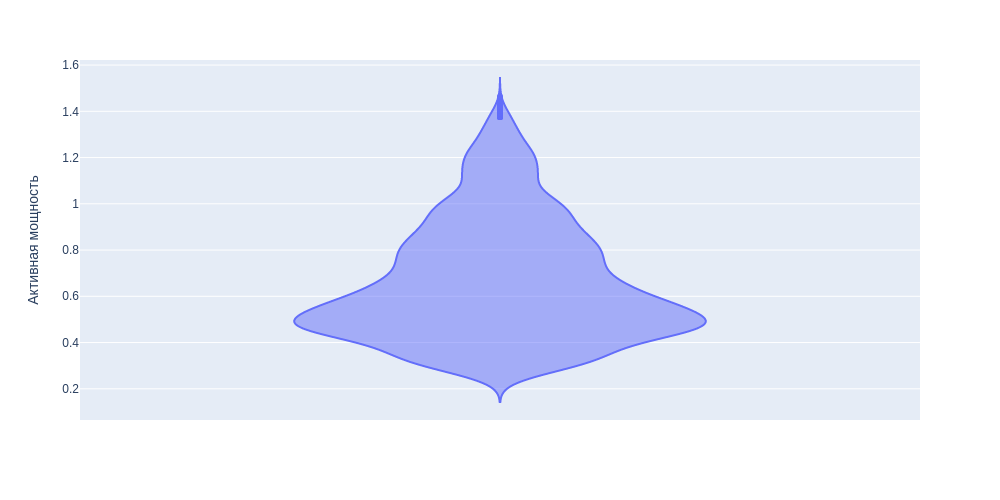

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64


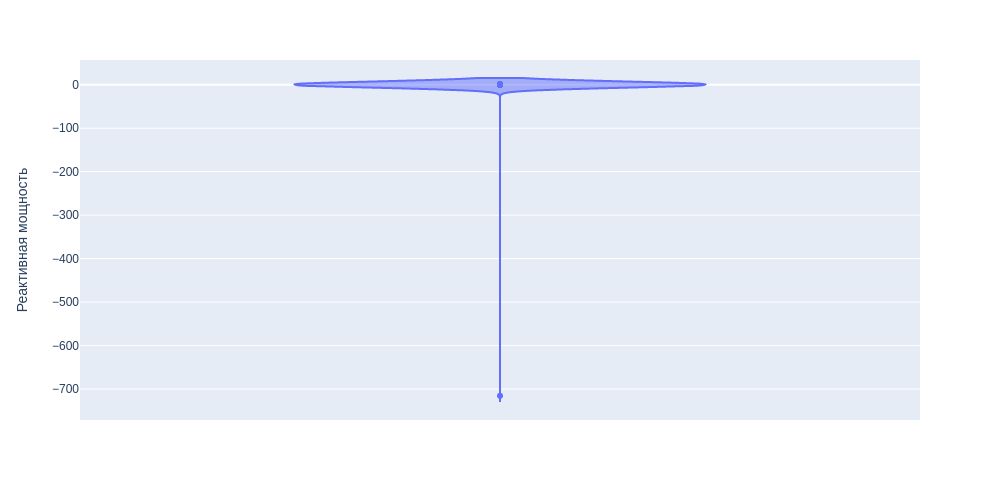

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

In [9]:
display(px.violin(arc, y='Активная мощность'))
print(arc['Активная мощность'].describe())

display(px.violin(arc, y='Реактивная мощность'))
arc['Реактивная мощность'].describe()

В реактивной мощности присутствует как минимум одно отрицательное значение. В этом столбце отрицательных значений быть не должно. От них мы избавимся во время предобработки. А пока просто отфильтруем их и построим Violin plot ещё раз.

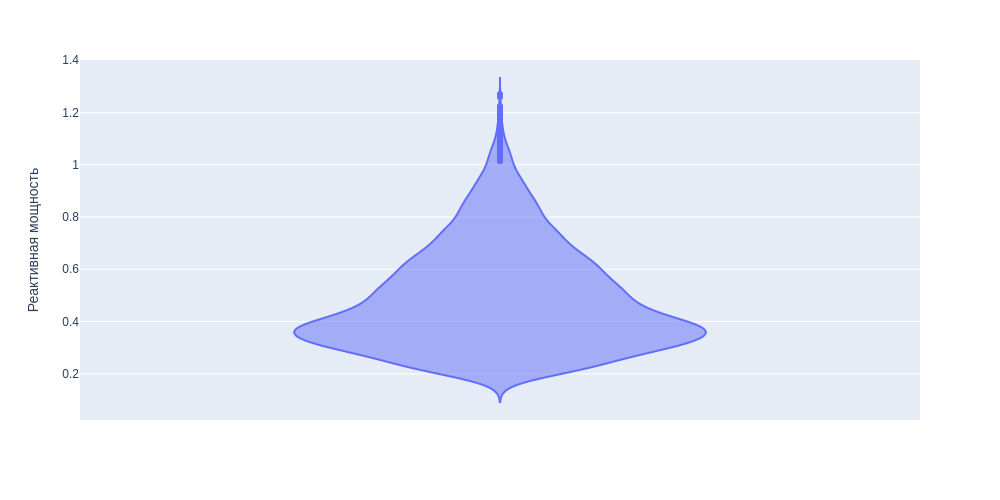

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: Реактивная мощность, dtype: float64

In [10]:
display(px.violin(
    arc[arc['Реактивная мощность'] > arc['Реактивная мощность'].min()],
    y='Реактивная мощность')
)

arc[arc['Реактивная мощность'] > arc['Реактивная мощность'].min()]['Реактивная мощность'].describe()

Это отрицательное значение было единственным.

### bulk и wire

In [11]:
bulk.info()
display(bulk.head())
wire.info()
wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Таблицы bulk и wire похожи по смыслу. Обе содержат данные об объёмах подаваемых материалов в каждый расплав. bulk содержит данные о сыпучих материалах, а wire - о проволочных. Каждый расплав должен входить в каждую таблицу не больше одного раза. Столбцы от `Bulk 1` до `Bulk 15` и от `Wire 1` до `Wire 9` отвечают за 15 разных по составу сыпучих материалов и 9 проволочных соответственно. Эти столбцы содержат объём соответсвующих материалов, которые были поданы в расплав на этапе. Пропуски в этих столбцах означают, что соответсвующий материал подан не был. Некоторые материалы подаются в расплав редко. Пропусков в столбцах с ключами нет.

Для обеих таблиц построим Violin plot для каждого столбца с объёмом материала.

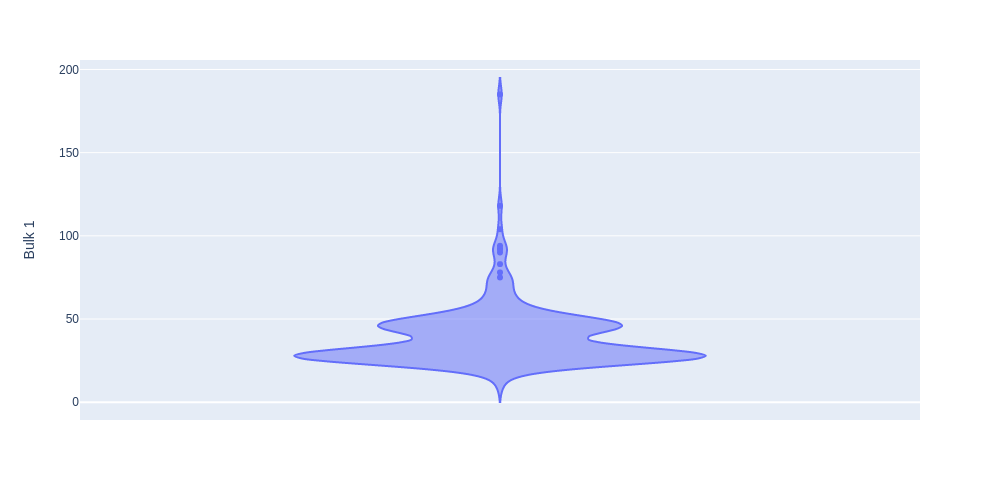

count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64


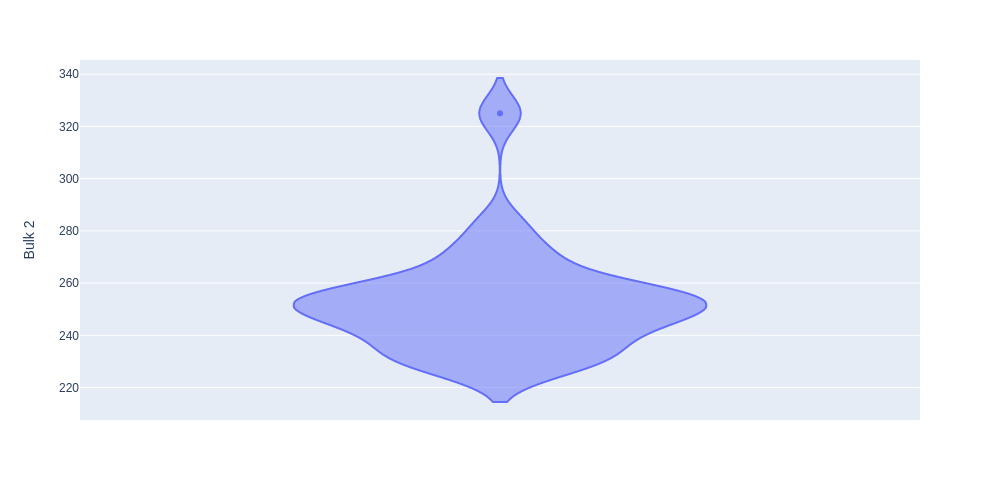

count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64


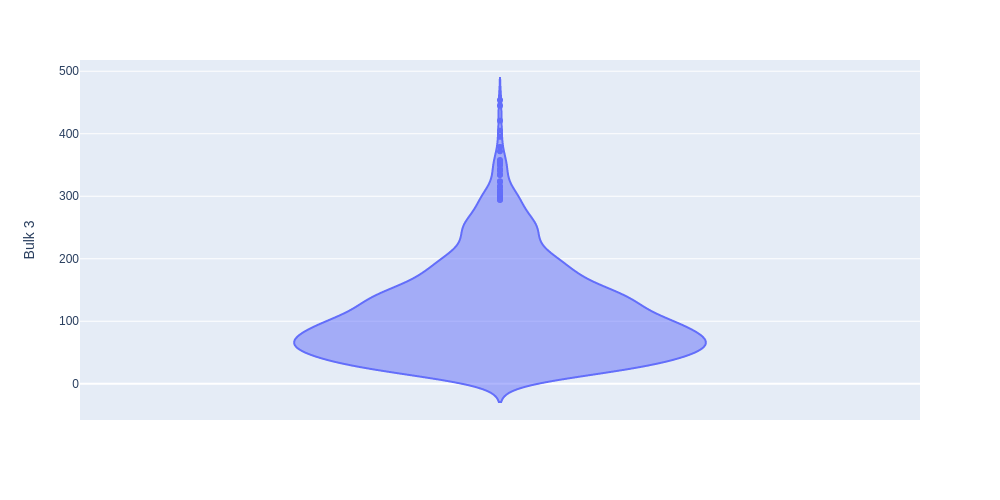

count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64


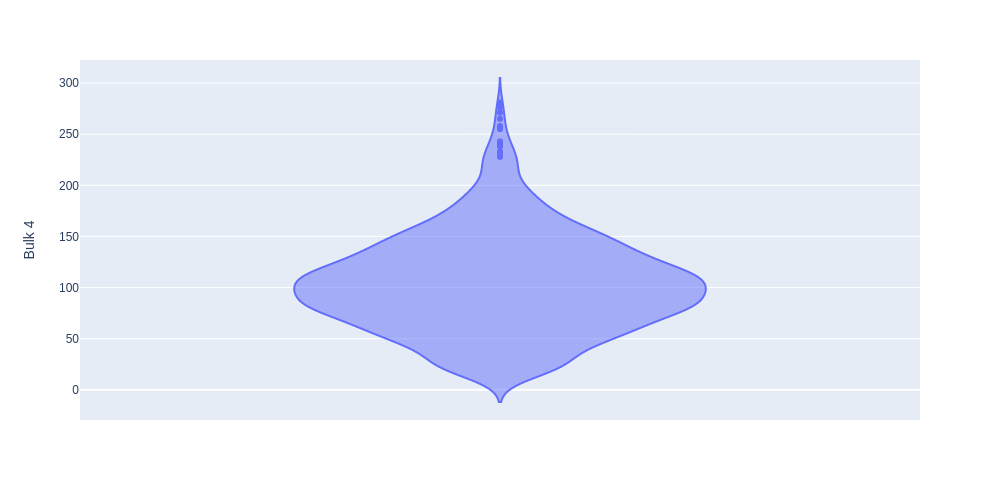

count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64


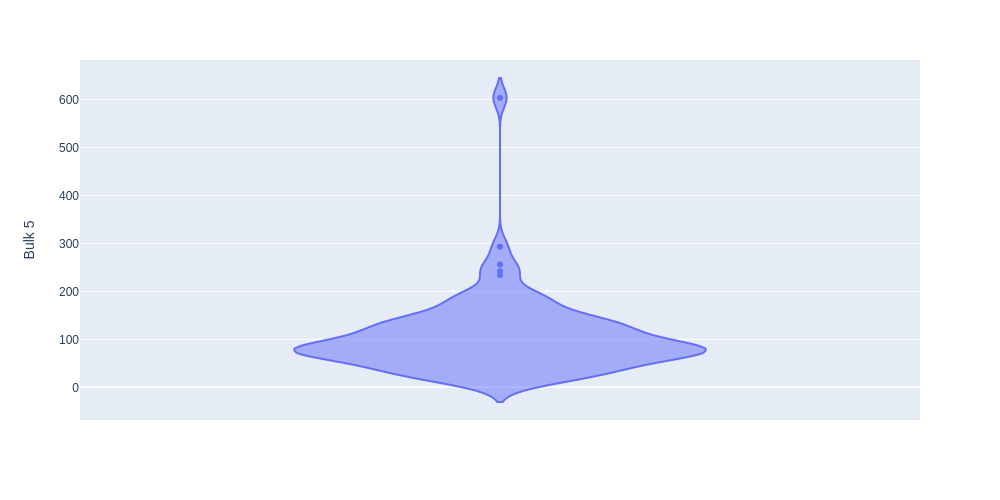

count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64


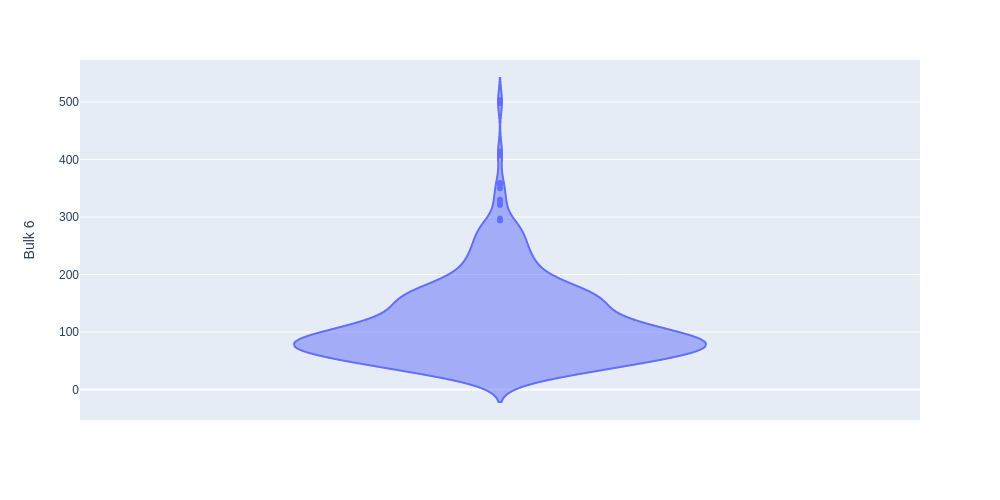

count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64


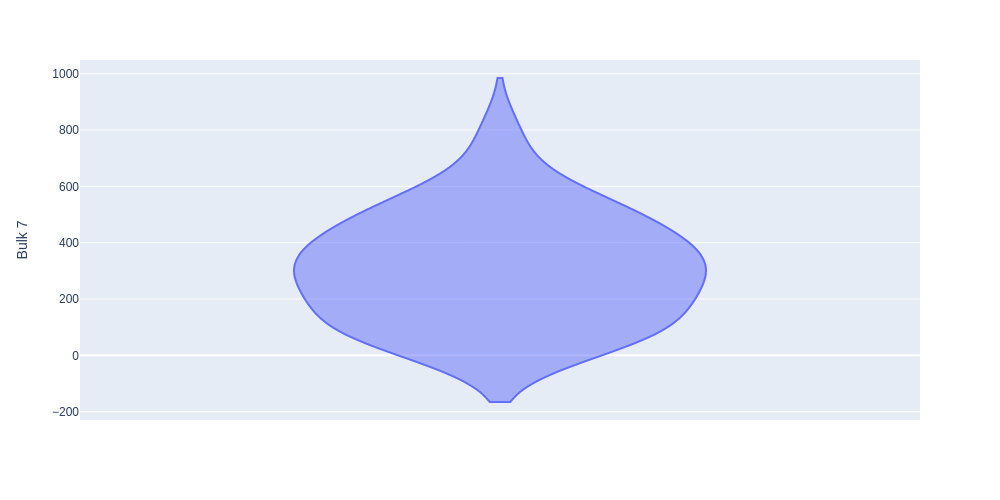

count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64


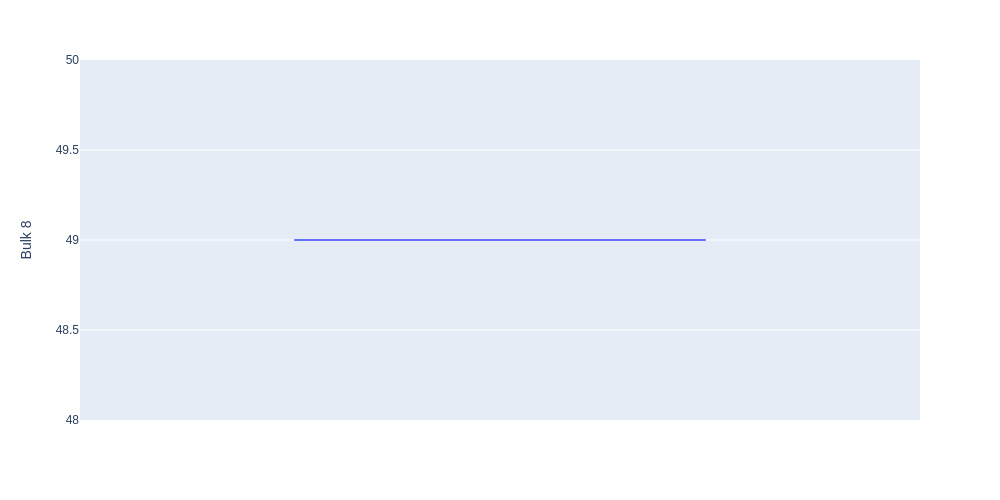

count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64


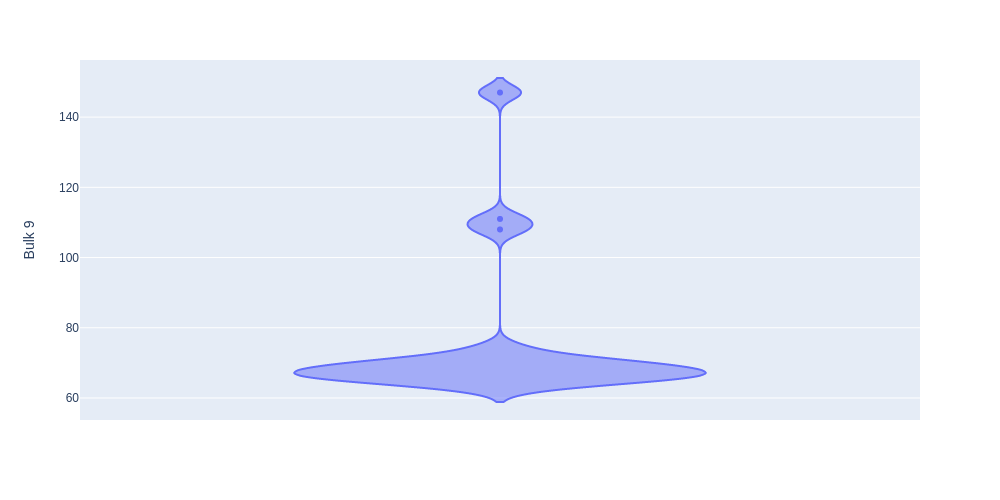

count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64


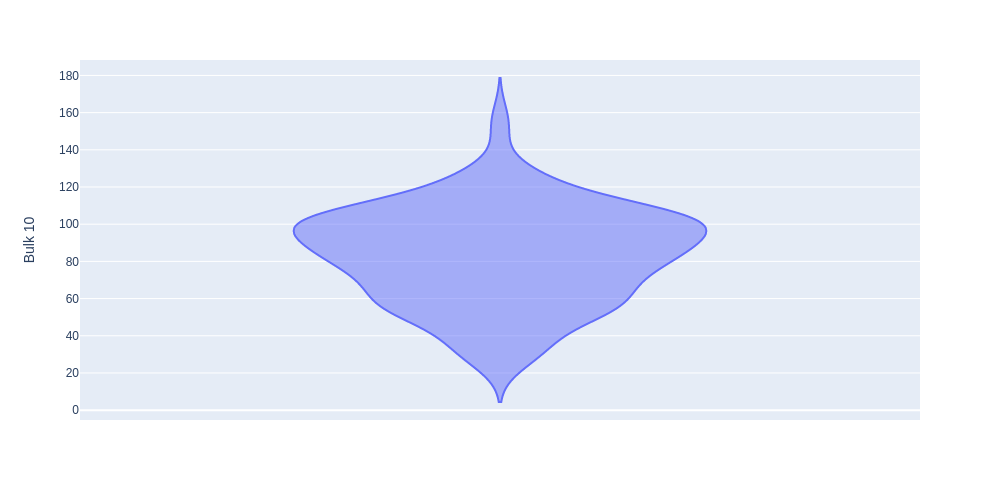

count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64


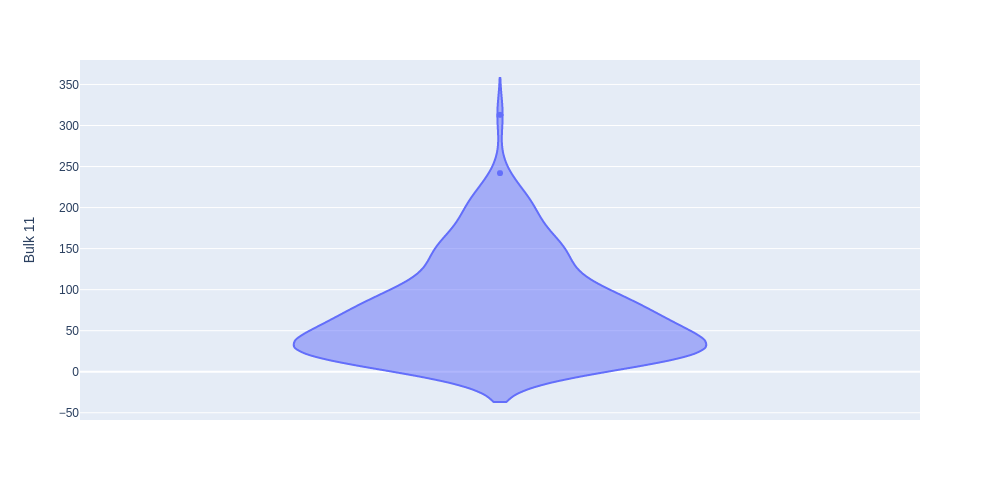

count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64


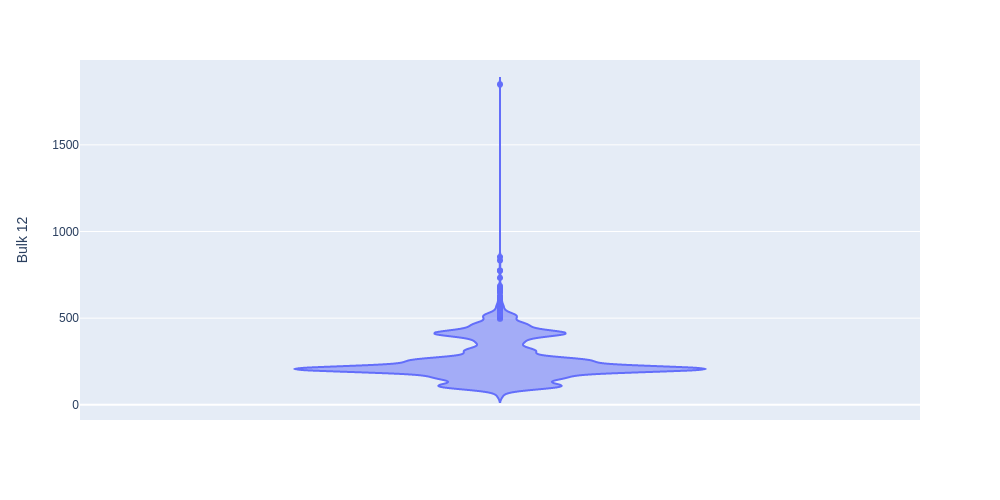

count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64


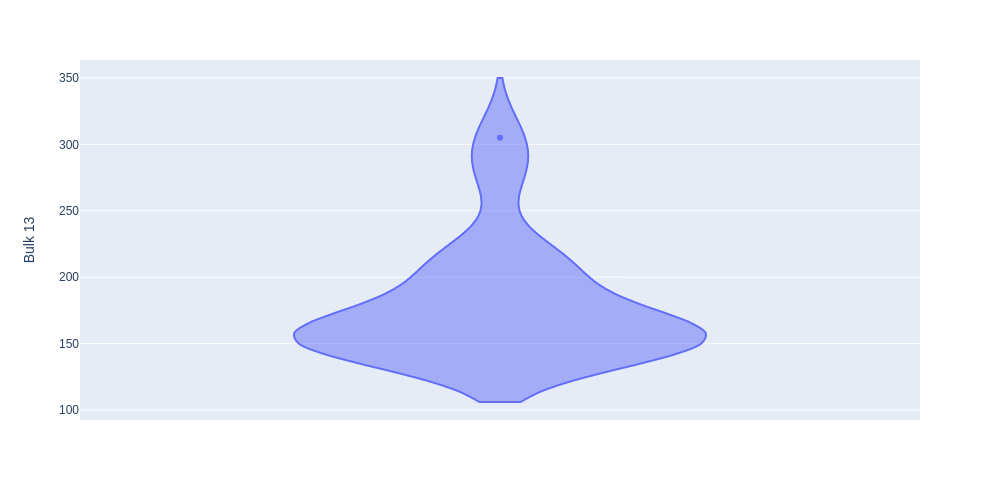

count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64


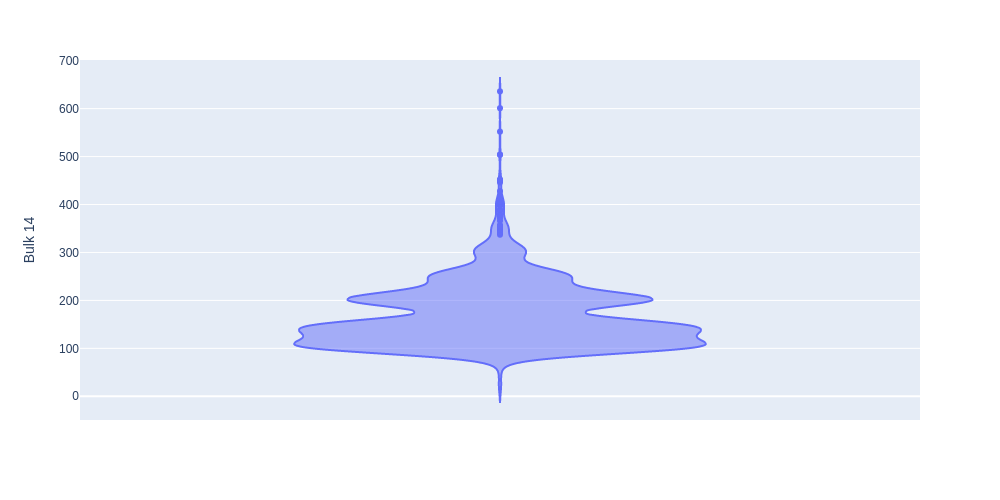

count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64


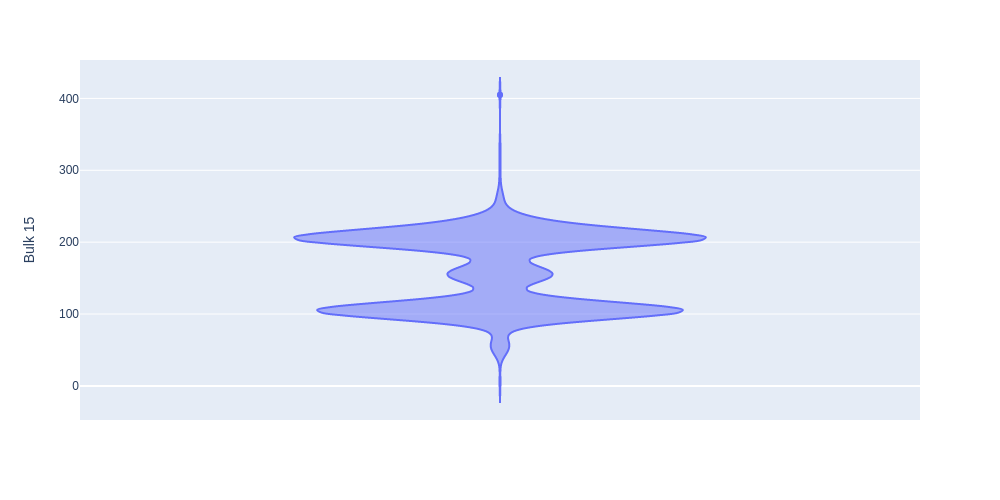

count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64


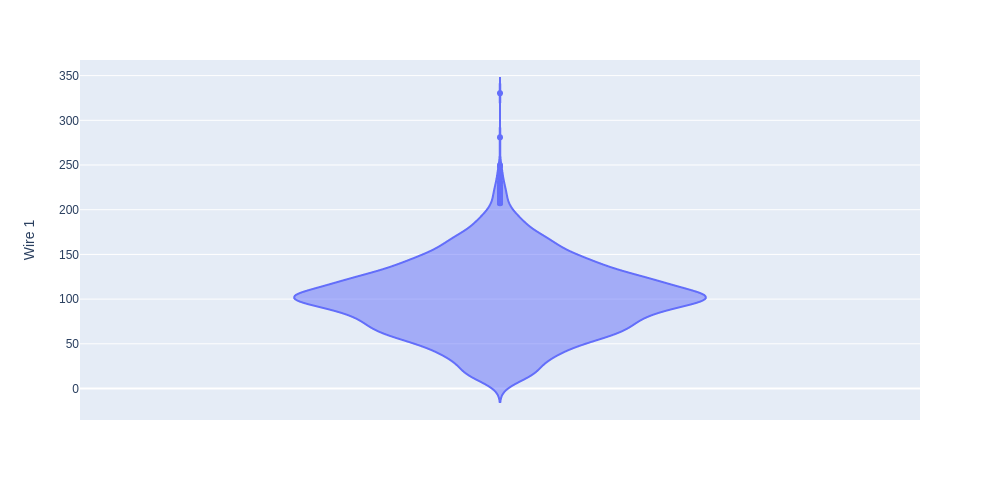

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64


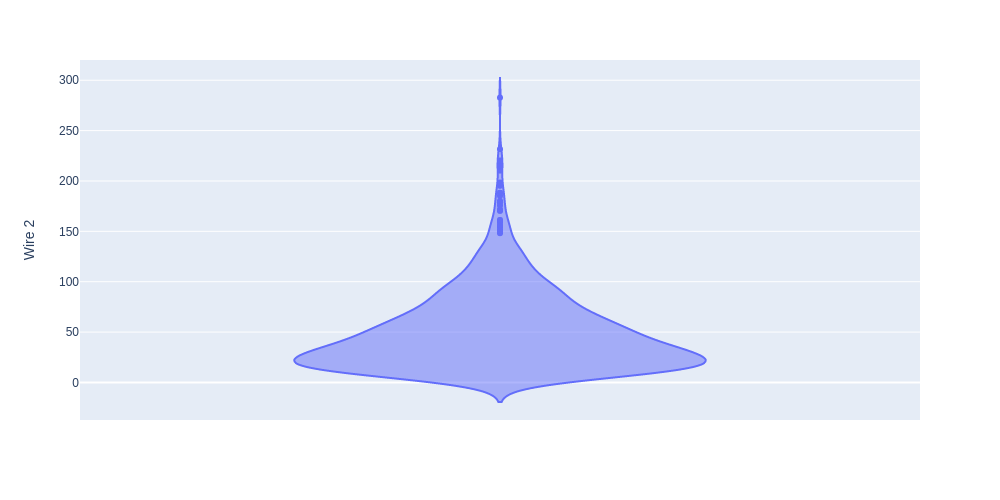

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64


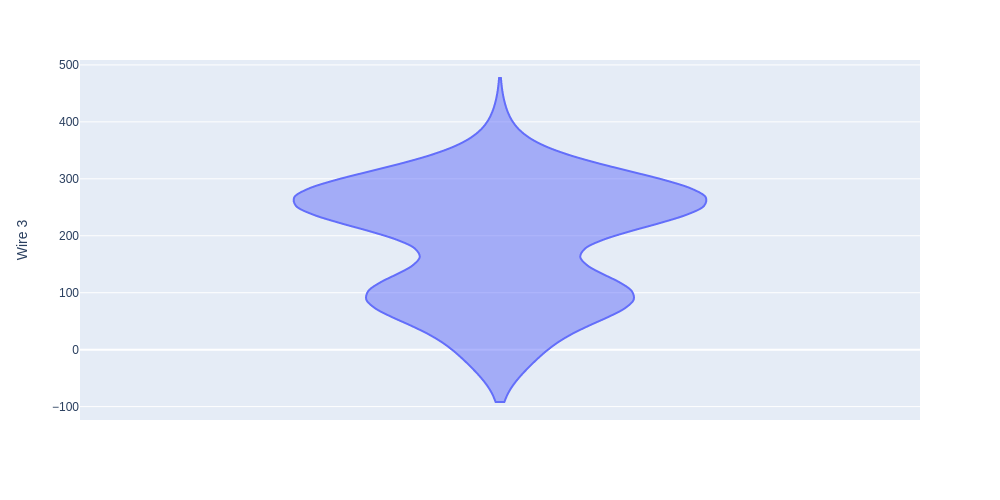

count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64


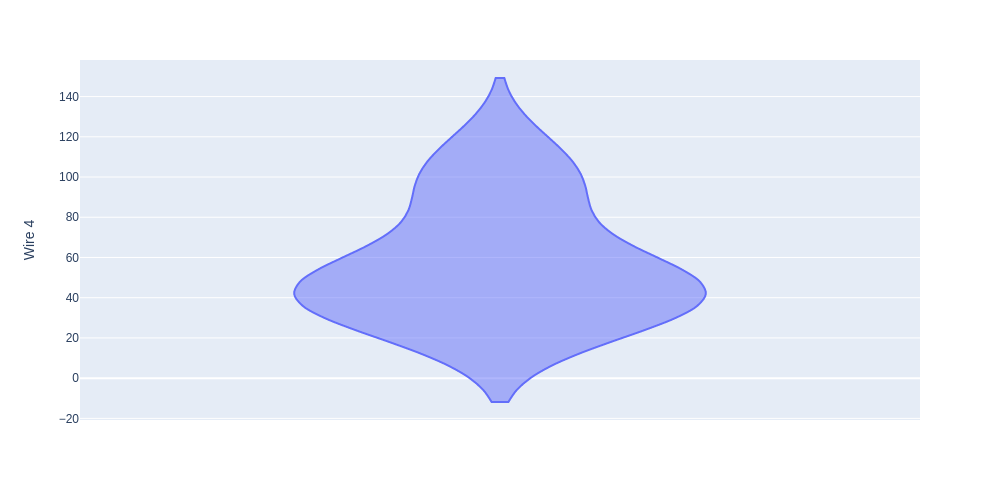

count     14.000000
mean      57.442841
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64


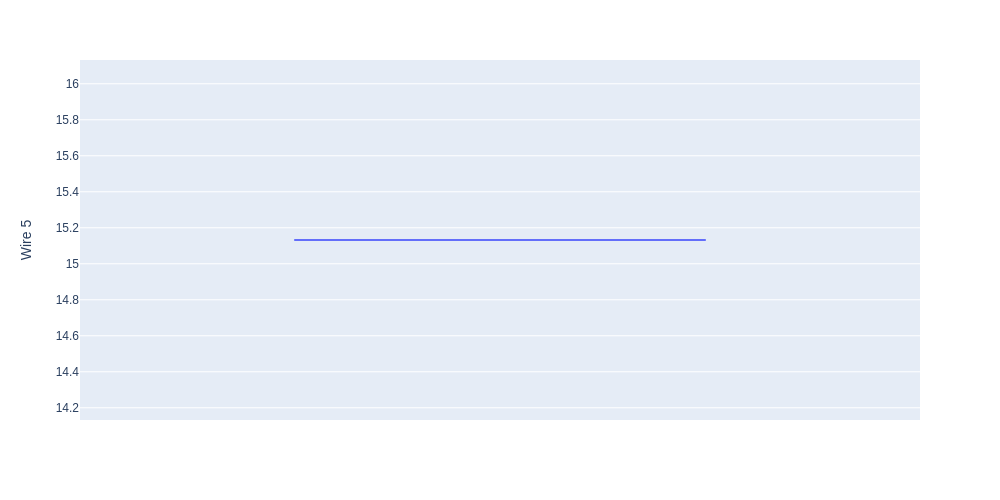

count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64


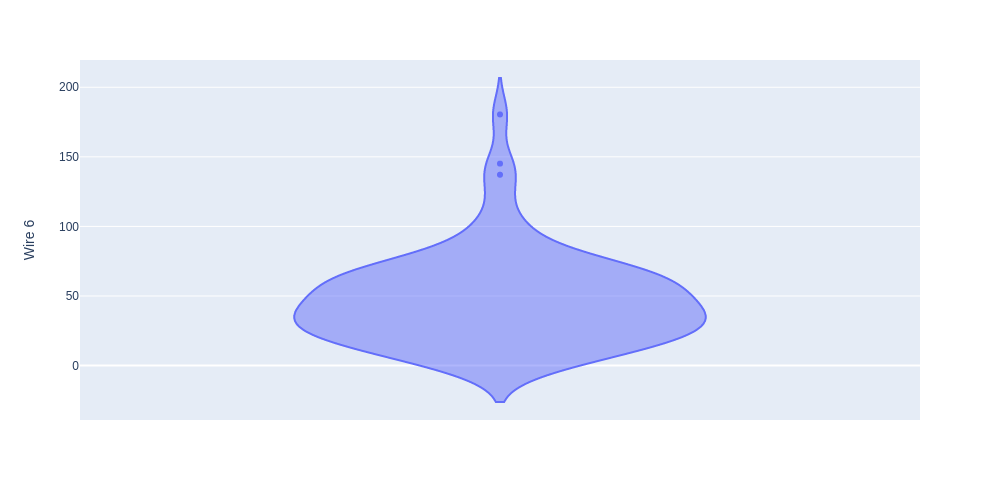

count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64


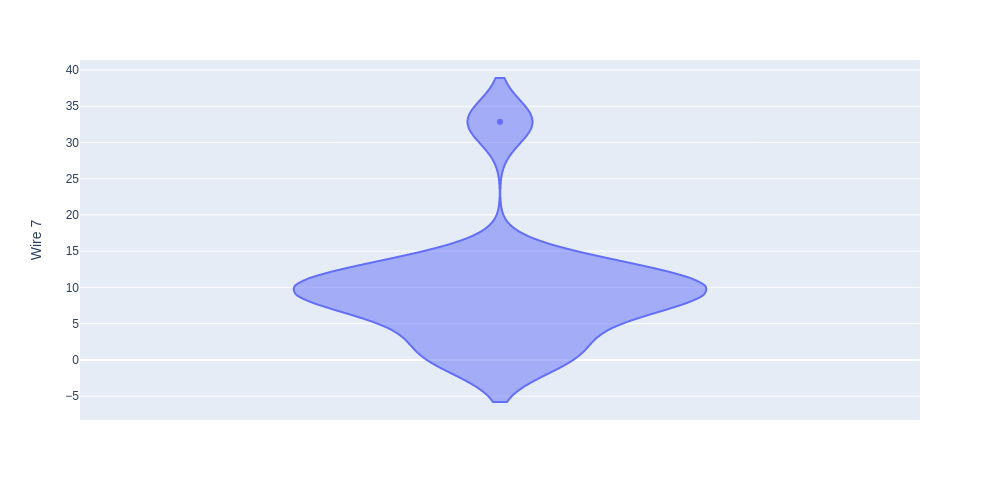

count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64


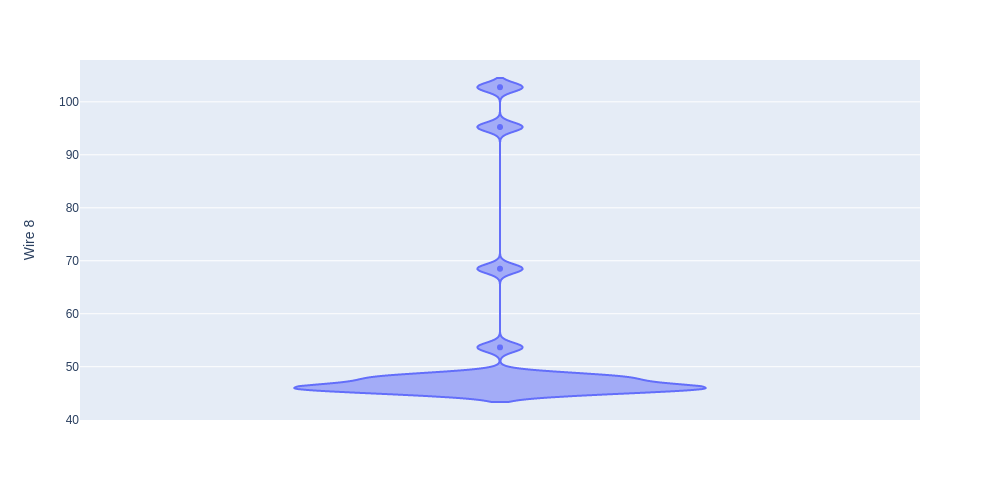

count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64


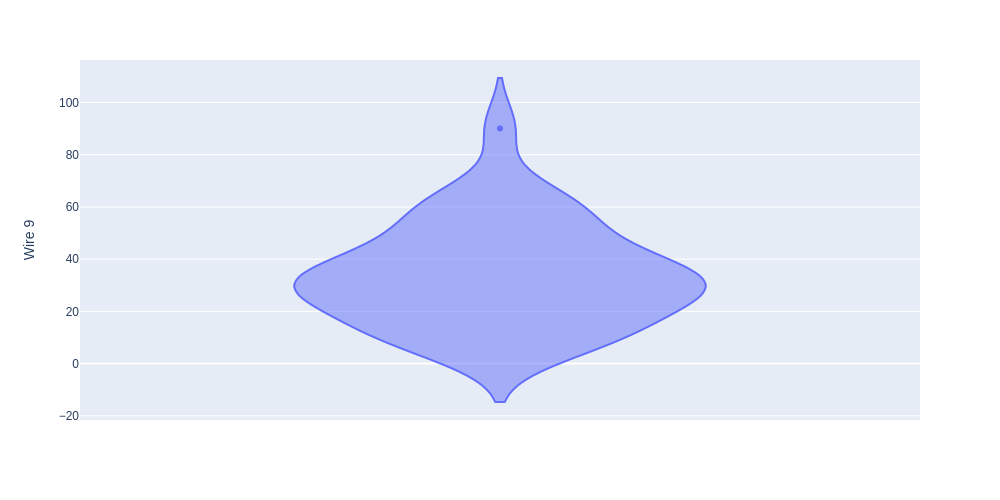

count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64


In [12]:
for i in range(1, 16):
    column = f'Bulk {i}'
    display(px.violin(bulk, y=column))
    print(bulk[column].describe())

for i in range(1, 10):
    column = f'Wire {i}'
    display(px.violin(wire, y=column))
    print(wire[column].describe())

Отрицательных значений в столбцах нет.

### bulk_time и wire_time

In [13]:
bulk_time.info()
display(bulk_time.head())
wire_time.info()
wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Таблицы bulk_time и wire_time похожи по смыслу и связаны с таблицами bulk и wire соответственно. Столбцы в этих таблицах отвечают за то же самое, но только значения столбцов `Bulk 1` - `Bulk 15` и `Wire 1` - `Wire 9` содержат не объём соответствующего материала из таблиц bulk и wire, а время его добавления. Эти столбцы тоже содержат пропуски, и они должны соответствовать пропускам в таблицах bulk и wire. Так ли это на самом деле проверим на валидации. Значения времени в этих таблицах имеют тип строки, что потом будет исправлено. Пропусков в столбцах с ключами нет. 

### gas

In [14]:
gas.info()
gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Таблица gas содержит данные для каждого расплава о продувке газом. Известно, что значение столбца `Газ 1` не должно быть отрицательным. Один и тот же расплав не должен входить в таблицу дважды. Ключи не должны повторяться. Пропусков в таблице нет.

Построим Violin plot для столбца `Газ 1`.

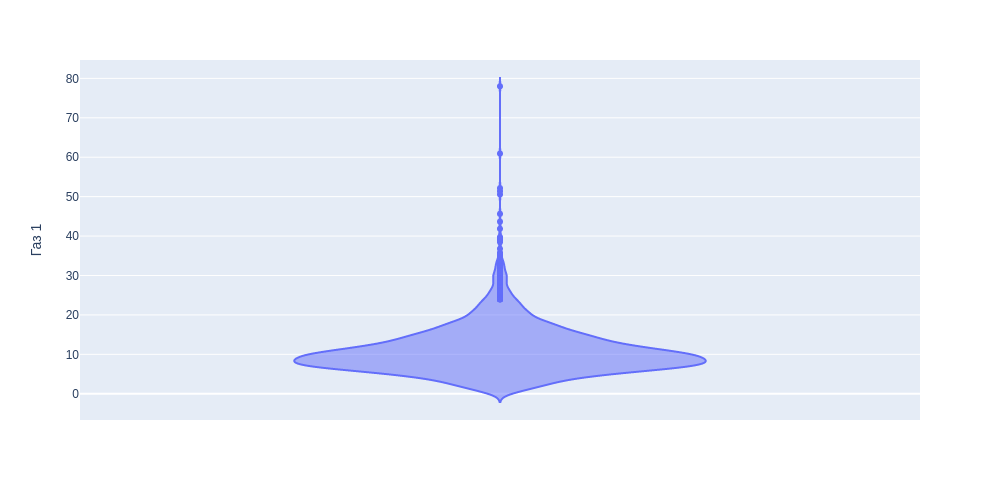

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [15]:
display(px.violin(gas, y='Газ 1'))
gas['Газ 1'].describe()

Отрицательных значений нет.

Проверим, нет ли подозрительных повторяющихся значений в столбце.

In [16]:
gas['Газ 1'].value_counts().max()

1

Повторяющихся значений нет.

### temp

In [17]:
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


В течении этапа у расплава замеряют температуру как минимум два раза: в начале этапа и в конце. Таблица temp для каждого замера каждого расплава содержит время замера и полученную температуру. Каждый ключ в таблице должен повторяться. Значение температуры первого замера температуры каждого расплава это известный признак, который будет подаваться модель. Значение температуры последнего замера - это целевой признак, который надо предсказать. Также для каждого расплава могут также присутствовать замеры между первым и последним. Их мы потом откинем. Пропуски есть только в столбце с температурой. Исправлять будем на валидации.

Посчитаем, какое минимальное и максимальное количество замеров температуры могло быть у одного расплава в таблице.

In [18]:
grouped = temp.groupby('key')['key'].count()
grouped.min(), grouped.max()

(1, 17)

В таблице всё же есть расплавы только с одной записью. Возможно, это записи с пропусками. В любом случае, с ними тоже разберёмся на валидации. Максимальное количество замеров для одного расплава - 17.

Проверим, нет ли подозрительных повторяющихся значений в столбце `Время замера`.

In [19]:
temp['Время замера'].value_counts().max()

1

Повторяющихся значений нет.

Проверим, нет ли подозрительных повторяющихся значений в столбце с температурой.

In [20]:
temp['Температура'].value_counts().head(10)

1593.0    445
1591.0    443
1589.0    437
1590.0    427
1588.0    427
1594.0    426
1587.0    419
1592.0    415
1595.0    385
1586.0    370
Name: Температура, dtype: int64

В таблице присутствуют частые повторения для некоторых значений. Возможно, диапазон значений довольно маленький, а дробные значения отсутствуют.

Проверим таблицу на наличие дробных температур.

In [21]:
temp[temp['Температура'] != temp['Температура'].round()]['Температура'].notna().sum()

0

Дробные температуры отсутствуют.

Построим для температур Violin plot.

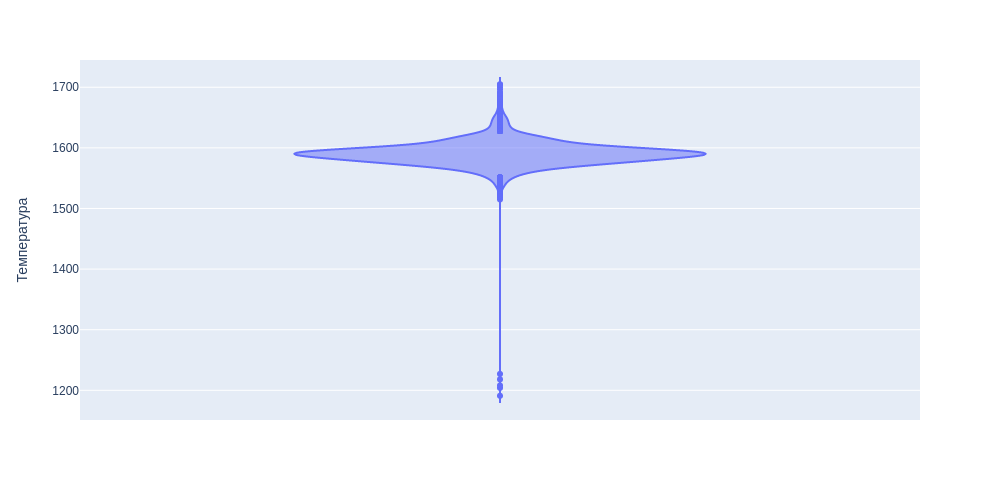

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

In [22]:
display(px.violin(temp, y='Температура'))
temp['Температура'].describe()

Диапазон большой, но это из-за выбросов. Выбросы начинаются где-то за диапазоном +-40 градусов, а основная масса находится в этом диапазоне. Также видны аномально низкие значения температуры, которые тоже надо будет завалидировать.

### Выводы

Таблицы удалось загрузить, но уже видно, что придётся их валидировать. В таблице с замерами температур присутствуют пропуски в столбце с температурой. В том же столбце присутствуют аномально низкие температуры. В таблице с нагревами есть одно отрицательное значение реактивной мощности. В таблицах, которые содержат только по одному вхождению для каждого расплава, немного разнится количество вхождений. Это значит, что есть расплавы, которые присутствуют не во всех таблицах. Ещё не известно, останется ли после валидации достаточно данных для модели. Также, из-за наличия этих проблем, вызывает сомнение качество самих данных. Качество модели на практике может оказаться хуже чем на тесте.

Также на многих Violin plot'ах видны выбросы. Ни для одного параметра точно не известно, какой диапазон является приемлемым. Известно только то, что значения температур не должены быть ниже 1400, а остальные не должны быть ниже нуля. Все остальные выбросы будут оставлены.

## Исправление таблиц

Переименуем названия столбцов во всех таблицах так, чтобы они соответствовали snake_case.

In [23]:
arc = arc.rename(columns={
    'Начало нагрева дугой': 'start',
    'Конец нагрева дугой': 'end',
    'Активная мощность': 'active',
    'Реактивная мощность': 'reactive'
})

arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   key       14876 non-null  int64  
 1   start     14876 non-null  object 
 2   end       14876 non-null  object 
 3   active    14876 non-null  float64
 4   reactive  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [24]:
columns = {}
columns_time = {}

for i in range(1, 16):
    columns[f'Bulk {i}'] = f'bulk_{i}'
    columns_time[f'Bulk {i}'] = f'bulk_{i}_time'
    
bulk = bulk.rename(columns=columns)
bulk_time = bulk_time.rename(columns=columns_time)

bulk.info()
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  --

In [25]:
columns = {}
columns_time = {}

for i in range(1, 10):
    columns[f'Wire {i}'] = f'wire_{i}'
    columns_time[f'Wire {i}'] = f'wire_{i}_time'
    
wire = wire.rename(columns=columns)
wire_time = wire_time.rename(columns=columns_time)

wire.info()
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          3081 non-null   int64 
 1   wire_1_time  3055 non-null   object
 2   wire_2_time  1079 non-null   object
 3   wire_3_time  63 non-null     object
 4   wire_4_time  14 non-null     object
 5 

In [26]:
gas = gas.rename(columns={'Газ 1': 'gas'})
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [27]:
temp = temp.rename(columns={'Время замера': 'time', 'Температура': 'temp'})
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18092 non-null  int64  
 1   time    18092 non-null  object 
 2   temp    14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Приведём все столбцы со временем к типу `datetime`.

In [28]:
format = '%Y-%m-%d %H:%M:%S'

arc['start'] = pd.to_datetime(arc['start'], format=format)
arc['end'] = pd.to_datetime(arc['end'], format=format)

arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       14876 non-null  int64         
 1   start     14876 non-null  datetime64[ns]
 2   end       14876 non-null  datetime64[ns]
 3   active    14876 non-null  float64       
 4   reactive  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [29]:
for i in range(1, 16):
    bulk_time[f'bulk_{i}_time'] = pd.to_datetime(bulk_time[f'bulk_{i}_time'], format=format)

bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk_1_time   252 non-null    datetime64[ns]
 2   bulk_2_time   22 non-null     datetime64[ns]
 3   bulk_3_time   1298 non-null   datetime64[ns]
 4   bulk_4_time   1014 non-null   datetime64[ns]
 5   bulk_5_time   77 non-null     datetime64[ns]
 6   bulk_6_time   576 non-null    datetime64[ns]
 7   bulk_7_time   25 non-null     datetime64[ns]
 8   bulk_8_time   1 non-null      datetime64[ns]
 9   bulk_9_time   19 non-null     datetime64[ns]
 10  bulk_10_time  176 non-null    datetime64[ns]
 11  bulk_11_time  177 non-null    datetime64[ns]
 12  bulk_12_time  2450 non-null   datetime64[ns]
 13  bulk_13_time  18 non-null     datetime64[ns]
 14  bulk_14_time  2806 non-null   datetime64[ns]
 15  bulk_15_time  2248 non-null   datetime

In [30]:
for i in range(1, 10):
    wire_time[f'wire_{i}_time'] = pd.to_datetime(wire_time[f'wire_{i}_time'], format=format)

wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   wire_1_time  3055 non-null   datetime64[ns]
 2   wire_2_time  1079 non-null   datetime64[ns]
 3   wire_3_time  63 non-null     datetime64[ns]
 4   wire_4_time  14 non-null     datetime64[ns]
 5   wire_5_time  1 non-null      datetime64[ns]
 6   wire_6_time  73 non-null     datetime64[ns]
 7   wire_7_time  11 non-null     datetime64[ns]
 8   wire_8_time  19 non-null     datetime64[ns]
 9   wire_9_time  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [31]:
temp['time'] = pd.to_datetime(temp['time'], format=format)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18092 non-null  int64         
 1   time    18092 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


## Валидация  и подготовка данных

Проверим, что в таблицах, где каждый расплав входит только один раз, ключи не повторяются.

In [32]:
(
    bulk['key'].duplicated().sum(),
    bulk_time['key'].duplicated().sum(),
    wire['key'].duplicated().sum(),
    wire_time['key'].duplicated().sum(),
    gas['key'].duplicated().sum()
)

(0, 0, 0, 0, 0)

Дубликатов ключей там, где их быть не должно, нет. В каждой из этих таблиц мы установим ключ в качестве индекса для удобства.

In [33]:
bulk = bulk.set_index('key')
bulk_time = bulk_time.set_index('key')
wire = wire.set_index('key')
wire_time = wire_time.set_index('key')
gas = gas.set_index('key')

gas.info()
gas.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas     3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


Уже сейчас начнём готовить признаки и объединять таблицы по ключу для удобства и производительности валидации. Каждый расплав должен быть в каждой таблице, так что при объединении будем брать строгое пересечение.

In [34]:
df = pd.concat([bulk, bulk_time, wire, wire_time, gas], axis=1, join='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023 entries, 1 to 3241
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   bulk_1        252 non-null    float64       
 1   bulk_2        22 non-null     float64       
 2   bulk_3        1293 non-null   float64       
 3   bulk_4        1012 non-null   float64       
 4   bulk_5        77 non-null     float64       
 5   bulk_6        571 non-null    float64       
 6   bulk_7        24 non-null     float64       
 7   bulk_8        1 non-null      float64       
 8   bulk_9        19 non-null     float64       
 9   bulk_10       176 non-null    float64       
 10  bulk_11       177 non-null    float64       
 11  bulk_12       2356 non-null   float64       
 12  bulk_13       18 non-null     float64       
 13  bulk_14       2709 non-null   float64       
 14  bulk_15       2234 non-null   float64       
 15  bulk_1_time   252 non-null    datetime

Часть расплавов откинулась.

Проверим, что каждому значению в столбцах bulk_i и wire_i соответствует значение в столбцах bulk_i_time и wire_i_time соответственно и наоборот.

In [35]:
material_columns = list(bulk.columns) + list(wire.columns)

for column in material_columns:
    df = df[df[column].isna() == df[f'{column}_time'].isna()]

df.shape[0]

3023

Столбцы полностью соответствуют друг другу и ничего удалять не пришлось.

Теперь можно упростить таблицу. Найдём суммарный объём для сыпучих и проволочных материалов для каждого расплава. Также нам придётся валидировать время замеров температур, так что также найдём для каждого расплава самое раннее и самое позднее время добавления любого материала в расплав. После этого удалим оригинальные столбцы, которые относятся к времени добавления материалов. Cтолбцы с объёмом добавленных материалов, могут оказаться важными, но мы всё-равно удалим часть из них в конце валидации, отталкиваясь от того, сколько пропусков будет в этих столбцах.

In [36]:
df['bulk'] = df[bulk.columns].sum(axis=1)
df['wire'] = df[wire.columns].sum(axis=1)

time_material_columns = list(bulk_time.columns) + list(wire_time.columns)
df['time_material_min'] = df[time_material_columns].min(axis=1)
df['time_material_max'] = df[time_material_columns].max(axis=1)

df = df.drop(time_material_columns, axis=1)

bulk = None
bulk_time = None
wire = None
wire_time = None

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023 entries, 1 to 3241
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bulk_1             252 non-null    float64       
 1   bulk_2             22 non-null     float64       
 2   bulk_3             1293 non-null   float64       
 3   bulk_4             1012 non-null   float64       
 4   bulk_5             77 non-null     float64       
 5   bulk_6             571 non-null    float64       
 6   bulk_7             24 non-null     float64       
 7   bulk_8             1 non-null      float64       
 8   bulk_9             19 non-null     float64       
 9   bulk_10            176 non-null    float64       
 10  bulk_11            177 non-null    float64       
 11  bulk_12            2356 non-null   float64       
 12  bulk_13            18 non-null     float64       
 13  bulk_14            2709 non-null   float64       
 14  bulk_15 

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,...,wire_5,wire_6,wire_7,wire_8,wire_9,gas,bulk,wire,time_material_min,time_material_max
key,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,29.749986,553.0,60.059998,2019-05-03 11:06:19,2019-05-03 11:28:48
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.555561,582.0,96.052315,2019-05-03 11:36:50,2019-05-03 11:53:30
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,28.554793,544.0,91.160157,2019-05-03 12:11:46,2019-05-03 12:32:39
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.841219,595.0,89.063515,2019-05-03 12:43:22,2019-05-03 12:58:00
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.413692,584.0,98.352796,2019-05-03 13:15:34,2019-05-03 13:34:12


Для дальнейшей валидации и отбора признаков создадим две дополнительные таблицы. Одна будет содержать первые замеры температур для каждого расплава из таблицы temp, а другая - последние. Значения температуры первых замеров это известный признак, а последних - целевой. В новых таблицах в качестве индекса укажем ключ.

In [37]:
temp_start = (temp.sort_values(by='time')
                  .groupby('key')
                  .head(1)
                  .set_index('key'))

temp_fin = (temp.sort_values(by='time')
                .groupby('key')
                .tail(1)
                .set_index('key'))

temp_start.info()
display(temp_start.head())

temp_fin.info()
temp_fin.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    3216 non-null   datetime64[ns]
 1   temp    3216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.4 KB


,time,temp
key,,
1,2019-05-03 11:02:04,1571.0
2,2019-05-03 11:34:04,1581.0
3,2019-05-03 12:06:44,1596.0
4,2019-05-03 12:39:27,1601.0
5,2019-05-03 13:11:03,1576.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    3216 non-null   datetime64[ns]
 1   temp    2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.4 KB


,time,temp
key,,
1,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:36:39,1602.0


Сбрасываем таблицу с температурами. Она нам больше не понадобится.

In [38]:
temp = None

В таблице с последними замерами температур довольно много пропусков в столбце с температурой. Это будущий целевой признак, так что придётся удалить.

In [39]:
temp_fin = temp_fin.dropna()
temp_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    2477 non-null   datetime64[ns]
 1   temp    2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 58.1 KB


Переименуем столбцы в двух новых таблицах.

In [40]:
temp_start = temp_start.rename(columns={'time': 'time_temp_start', 'temp': 'temp_start'})
temp_fin = temp_fin.rename(columns={'time': 'time_temp_fin', 'temp': 'temp_fin'})

temp_start.info()
temp_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_temp_start  3216 non-null   datetime64[ns]
 1   temp_start       3216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time_temp_fin  2477 non-null   datetime64[ns]
 1   temp_fin       2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 58.1 KB


Добавим две новые таблицы с нашим признакам.

In [41]:
df = pd.concat([df, temp_start, temp_fin], axis=1, join='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 1 to 2499
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bulk_1             199 non-null    float64       
 1   bulk_2             13 non-null     float64       
 2   bulk_3             960 non-null    float64       
 3   bulk_4             812 non-null    float64       
 4   bulk_5             53 non-null     float64       
 5   bulk_6             439 non-null    float64       
 6   bulk_7             13 non-null     float64       
 7   bulk_8             1 non-null      float64       
 8   bulk_9             13 non-null     float64       
 9   bulk_10            143 non-null    float64       
 10  bulk_11            130 non-null    float64       
 11  bulk_12            1812 non-null   float64       
 12  bulk_13            14 non-null     float64       
 13  bulk_14            2068 non-null   float64       
 14  bulk_15 

Данные по некоторым расплавам отсеклись от пересечения. И, судя по размеру новой таблицы, не только из-за удалённых пропусков в таблице с финальными температурами.

Мы уже нашли расплав, у которого была отрицательная реактивная мощность. Данные об этом расплаве лучше целиком удалить из таблицы нагревов. Найдём его ключ.

In [42]:
arc.query('reactive < 0')

,key,start,end,active,reactive
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Отфильтруем все записи с этим ключом.

In [43]:
print('Before:', arc.shape[0])
arc = arc.query('key != 2116').copy()
print('After:', arc.shape[0])

Before: 14876
After: 14872


Удалили 4 записи.

Проверим, что начало каждого нагрева случается до конца нагрева.

In [44]:
(arc['start'] > arc['end']).sum()

0

Аномалий с началом и концом нагрева нет.

У каждого расплава может быть несколько нагревов. Надо как-то агрегировать информацию о мощности всех нагревов для каждого расплава. Для каждого нагрева можно найти общую мощность. Это корень из суммы квадратов активной и реактивной мощностей. Потом при группировке общую мощность всех нагревов каждого расплава можно просто сложить.

Вычислим общую мощность каждого нагрева.

In [45]:
arc['pow'] = (arc['active']**2 + arc['reactive']**2)**0.5

arc.info()
arc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       14872 non-null  int64         
 1   start     14872 non-null  datetime64[ns]
 2   end       14872 non-null  datetime64[ns]
 3   active    14872 non-null  float64       
 4   reactive  14872 non-null  float64       
 5   pow       14872 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 813.3 KB


,key,start,end,active,reactive,pow
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


Откинем столбцы с активной и реактивной мощностями.

In [46]:
arc = arc.drop(['active', 'reactive'], axis=1)
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     14872 non-null  int64         
 1   start   14872 non-null  datetime64[ns]
 2   end     14872 non-null  datetime64[ns]
 3   pow     14872 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 580.9 KB


Вычислим длительность каждого нагрева в секундах.

In [47]:
arc['time_interval'] = (arc['end'] - arc['start']).dt.seconds

arc.info()
arc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            14872 non-null  int64         
 1   start          14872 non-null  datetime64[ns]
 2   end            14872 non-null  datetime64[ns]
 3   pow            14872 non-null  float64       
 4   time_interval  14872 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 697.1 KB


,key,start,end,pow,time_interval
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.722536,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.642824,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,1.079934,148


Сгруппируем таблицу. Для каждого расплава найдём суммарное время нагрева, суммарную общую мощность, время начала первого нагрева, время конца последнего нагрева.

In [48]:
arc_grouped = pd.DataFrame()
groups = arc.groupby('key')

arc_grouped['heat_time_interval'] = groups['time_interval'].sum()
arc_grouped['pow'] = groups['pow'].sum()
arc_grouped['heat_start'] = groups['start'].min()
arc_grouped['heat_end'] = groups['end'].max()

arc_grouped.info()
arc_grouped.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   heat_time_interval  3213 non-null   int64         
 1   pow                 3213 non-null   float64       
 2   heat_start          3213 non-null   datetime64[ns]
 3   heat_end            3213 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 125.5 KB


,heat_time_interval,pow,heat_start,heat_end
key,,,,
1,1098,3.718736,2019-05-03 11:02:14,2019-05-03 11:28:37
2,811,2.588349,2019-05-03 11:34:14,2019-05-03 11:53:18
3,655,5.019223,2019-05-03 12:06:54,2019-05-03 12:32:19
4,741,3.400038,2019-05-03 12:39:37,2019-05-03 12:57:50
5,869,2.816980,2019-05-03 13:11:13,2019-05-03 13:33:55


Добавим получившуюся таблицу к нашим признакам.

In [49]:
df = pd.concat([df, arc_grouped], axis=1, join='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 1 to 2499
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bulk_1              199 non-null    float64       
 1   bulk_2              13 non-null     float64       
 2   bulk_3              960 non-null    float64       
 3   bulk_4              812 non-null    float64       
 4   bulk_5              53 non-null     float64       
 5   bulk_6              437 non-null    float64       
 6   bulk_7              13 non-null     float64       
 7   bulk_8              1 non-null      float64       
 8   bulk_9              13 non-null     float64       
 9   bulk_10             143 non-null    float64       
 10  bulk_11             130 non-null    float64       
 11  bulk_12             1812 non-null   float64       
 12  bulk_13             14 non-null     float64       
 13  bulk_14             2067 non-null   float64     

Отпала ещё пара расплавов.

Проверим, что для каждого расплава первый замер температуры происходит строго до последнего. У некоторых расплавов мог быть только один замер. Также проверим, что для каждого расплава первый замер температуры случается до добавления любых материалов в расплав и нагревов, а последний - после.

In [50]:
df = df.query('time_temp_start < time_temp_fin').copy()
df = df.query('time_temp_start <= time_material_min').copy()
df = df.query('time_temp_start <= heat_start').copy()
df = df.query('time_temp_fin >= time_material_max').copy()
df = df.query('time_temp_fin >= heat_end').copy()

df.shape[0]

2328

Аномалий с временами нет.

Отбрасываем все столбцы с типом `datetime`.

In [51]:
df = df.select_dtypes(exclude='datetime64[ns]').copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bulk_1              199 non-null    float64
 1   bulk_2              13 non-null     float64
 2   bulk_3              960 non-null    float64
 3   bulk_4              812 non-null    float64
 4   bulk_5              53 non-null     float64
 5   bulk_6              437 non-null    float64
 6   bulk_7              13 non-null     float64
 7   bulk_8              1 non-null      float64
 8   bulk_9              13 non-null     float64
 9   bulk_10             143 non-null    float64
 10  bulk_11             130 non-null    float64
 11  bulk_12             1812 non-null   float64
 12  bulk_13             14 non-null     float64
 13  bulk_14             2067 non-null   float64
 14  bulk_15             1699 non-null   float64
 15  wire_1              2305 non-null   float64
 16  wire_2

Проверим, имеются ли у нас теперь температуры меньше 1400.

In [52]:
df.query('temp_start <= 1400 or temp_fin <= 1400')

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,...,wire_7,wire_8,wire_9,gas,bulk,wire,temp_start,temp_fin,heat_time_interval,pow
key,,,,,,,,,,,,,,,,,,,,,
867,NaN,NaN,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11.616807,691.0,193.587684,1191.0,1599.0,969,6.044517
1214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.933558,431.0,53.118000,1208.0,1591.0,481,2.523002
1619,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.542025,45.0,200.321678,1218.0,1590.0,246,1.245024
2052,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.639928,494.0,116.014076,1227.0,1592.0,633,3.692965


Есть 4 расплава, у которых температура на старте этапа была меньше 1400. Это аномальные значения. Удалим данные о них.

In [53]:
df = df.query('temp_start > 1400 and temp_fin > 1400').copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bulk_1              199 non-null    float64
 1   bulk_2              13 non-null     float64
 2   bulk_3              958 non-null    float64
 3   bulk_4              811 non-null    float64
 4   bulk_5              53 non-null     float64
 5   bulk_6              437 non-null    float64
 6   bulk_7              13 non-null     float64
 7   bulk_8              1 non-null      float64
 8   bulk_9              13 non-null     float64
 9   bulk_10             143 non-null    float64
 10  bulk_11             130 non-null    float64
 11  bulk_12             1809 non-null   float64
 12  bulk_13             14 non-null     float64
 13  bulk_14             2064 non-null   float64
 14  bulk_15             1696 non-null   float64
 15  wire_1              2301 non-null   float64
 16  wire_2

Вот теперь можно думать о том, какие из столбцов с материалами нам нужны. Удалим все те, в которых заполненых значений меньше 400.

In [54]:
for column in material_columns:
    if df[column].notna().sum() < 400:
        df = df.drop(column, axis=1)
        
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bulk_3              958 non-null    float64
 1   bulk_4              811 non-null    float64
 2   bulk_6              437 non-null    float64
 3   bulk_12             1809 non-null   float64
 4   bulk_14             2064 non-null   float64
 5   bulk_15             1696 non-null   float64
 6   wire_1              2301 non-null   float64
 7   wire_2              809 non-null    float64
 8   gas                 2324 non-null   float64
 9   bulk                2324 non-null   float64
 10  wire                2324 non-null   float64
 11  temp_start          2324 non-null   float64
 12  temp_fin            2324 non-null   float64
 13  heat_time_interval  2324 non-null   int64  
 14  pow                 2324 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 290.5 KB


Среди признаков пропуски есть только в оригинальных столбцах с объёмами добавленных материалов, где пропуск означает, что соответствующий материал добавлен не был. Их можно заполнить нулями.

In [55]:
df = df.fillna(0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bulk_3              2324 non-null   float64
 1   bulk_4              2324 non-null   float64
 2   bulk_6              2324 non-null   float64
 3   bulk_12             2324 non-null   float64
 4   bulk_14             2324 non-null   float64
 5   bulk_15             2324 non-null   float64
 6   wire_1              2324 non-null   float64
 7   wire_2              2324 non-null   float64
 8   gas                 2324 non-null   float64
 9   bulk                2324 non-null   float64
 10  wire                2324 non-null   float64
 11  temp_start          2324 non-null   float64
 12  temp_fin            2324 non-null   float64
 13  heat_time_interval  2324 non-null   int64  
 14  pow                 2324 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 290.5 KB


,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas,bulk,wire,temp_start,temp_fin,heat_time_interval,pow
key,,,,,,,,,,,,,,,
1,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,553.0,60.059998,1571.0,1613.0,1098,3.718736
2,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,582.0,96.052315,1581.0,1602.0,811,2.588349
3,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,544.0,91.160157,1596.0,1599.0,655,5.019223
4,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,595.0,89.063515,1601.0,1625.0,741,3.400038
5,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,584.0,98.352796,1576.0,1602.0,869,2.816980


Признаки готовы к осмотру.

## Анализ признаков

Создадим для анализа новый признак. Это будет просто суммарный объём как сыпучих, так и проволочных материалов. Возможно, таким образом мы найдём корреляции, которые иначе не будут видны.

In [56]:
df['material'] = df['bulk'] + df['wire']

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bulk_3              2324 non-null   float64
 1   bulk_4              2324 non-null   float64
 2   bulk_6              2324 non-null   float64
 3   bulk_12             2324 non-null   float64
 4   bulk_14             2324 non-null   float64
 5   bulk_15             2324 non-null   float64
 6   wire_1              2324 non-null   float64
 7   wire_2              2324 non-null   float64
 8   gas                 2324 non-null   float64
 9   bulk                2324 non-null   float64
 10  wire                2324 non-null   float64
 11  temp_start          2324 non-null   float64
 12  temp_fin            2324 non-null   float64
 13  heat_time_interval  2324 non-null   int64  
 14  pow                 2324 non-null   float64
 15  material            2324 non-null   float64
dtypes: flo

,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas,bulk,wire,temp_start,temp_fin,heat_time_interval,pow,material
key,,,,,,,,,,,,,,,,
1,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,553.0,60.059998,1571.0,1613.0,1098,3.718736,613.059998
2,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,582.0,96.052315,1581.0,1602.0,811,2.588349,678.052315
3,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,544.0,91.160157,1596.0,1599.0,655,5.019223,635.160157
4,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,595.0,89.063515,1601.0,1625.0,741,3.400038,684.063515
5,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,584.0,98.352796,1576.0,1602.0,869,2.816980,682.352796


Построим Violin plot для всех столбцов, кроме столбцов с объёмами конкретных материалов.

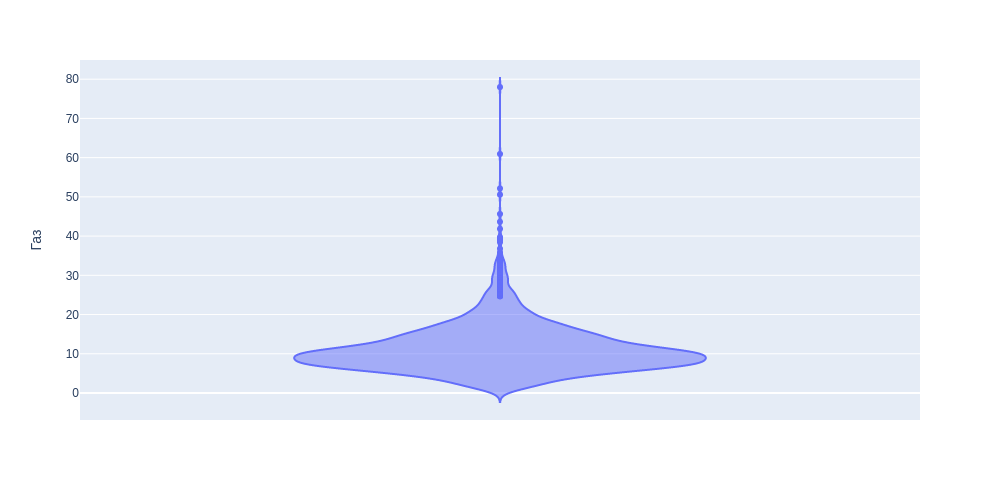

count    2324.000000
mean       11.378854
std         6.397008
min         0.008399
25%         7.282534
50%        10.100687
75%        14.218487
max        77.995040
Name: gas, dtype: float64


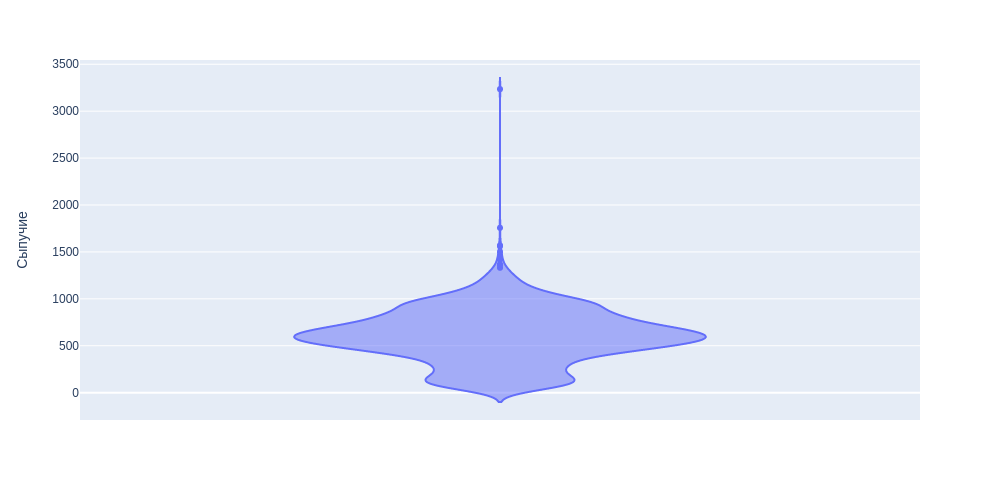

count    2324.000000
mean      610.083046
std       287.574952
min        19.000000
25%       440.000000
50%       609.000000
75%       796.000000
max      3235.000000
Name: bulk, dtype: float64


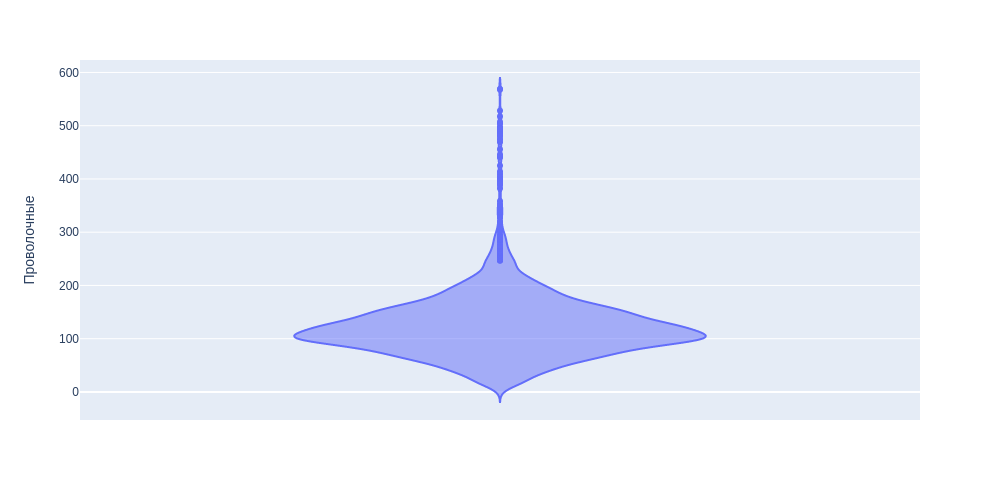

count    2324.000000
mean      125.203274
std        63.690752
min         1.918800
25%        89.048700
50%       116.106121
75%       151.555294
max       568.777664
Name: wire, dtype: float64


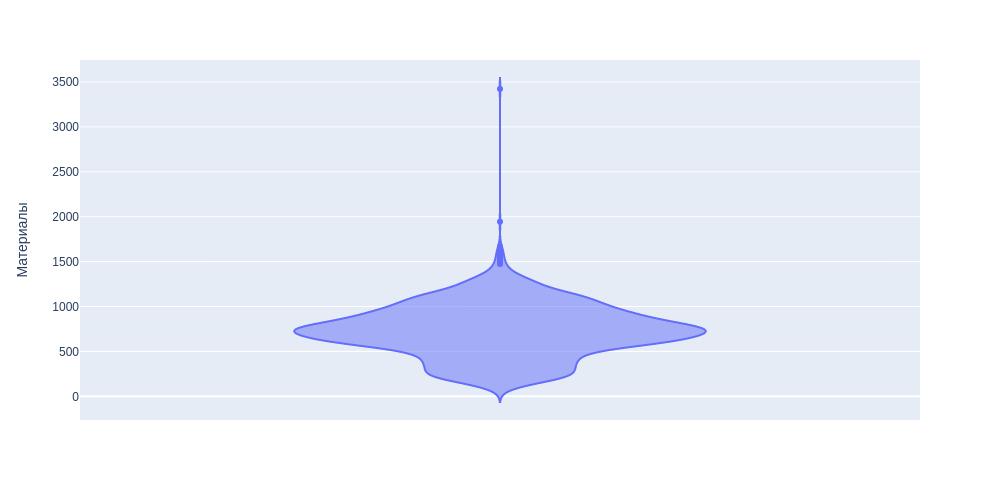

count    2324.000000
mean      735.286320
std       295.000164
min        58.065762
25%       562.172256
50%       735.158237
75%       926.032102
max      3423.228550
Name: material, dtype: float64


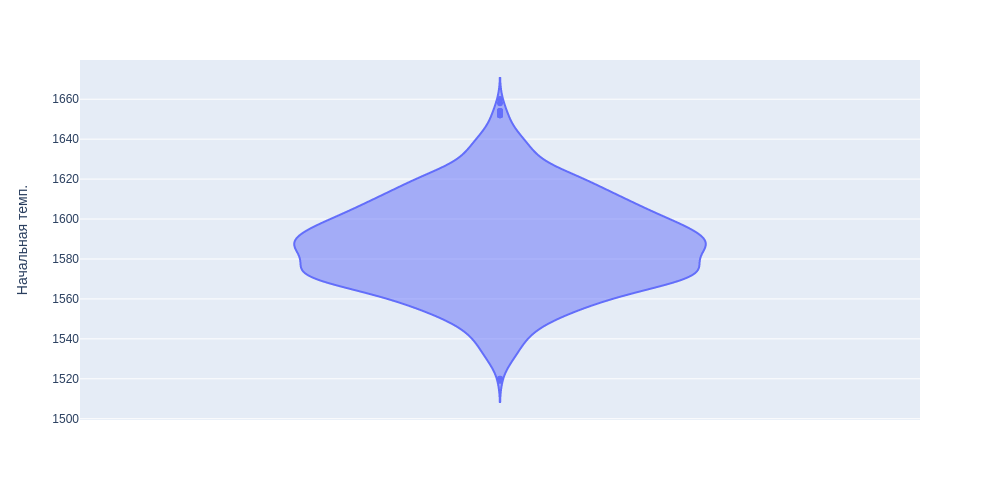

count    2324.000000
mean     1587.368761
std        23.627590
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: temp_start, dtype: float64


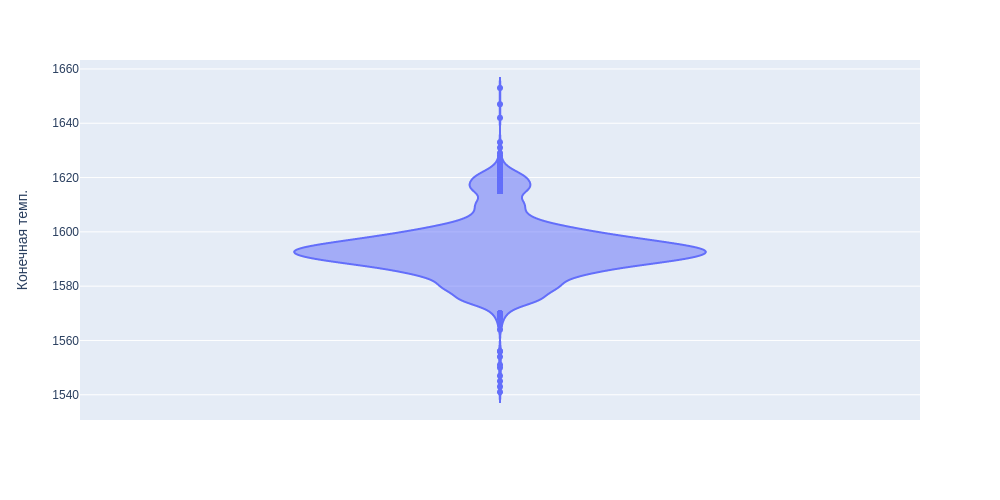

count    2324.000000
mean     1593.372633
std        11.207457
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temp_fin, dtype: float64


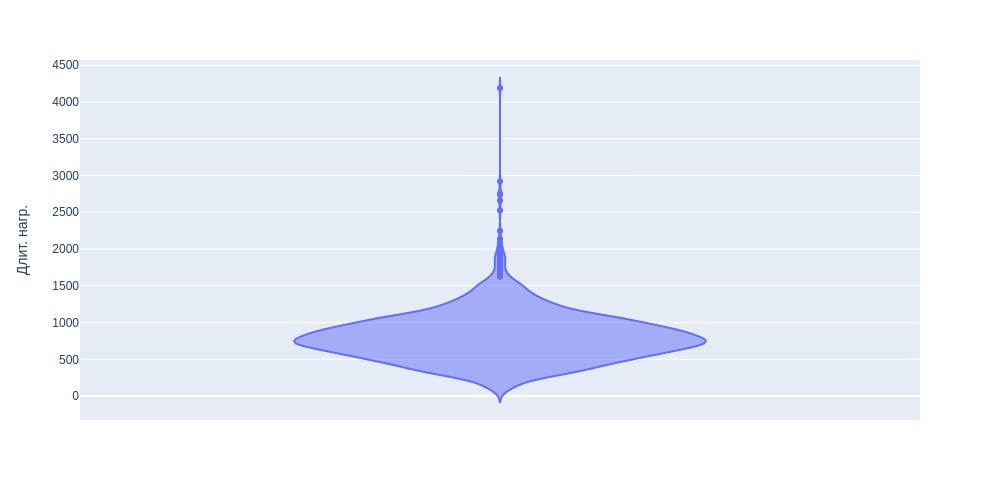

count    2324.000000
mean      808.196644
std       340.813828
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: heat_time_interval, dtype: float64


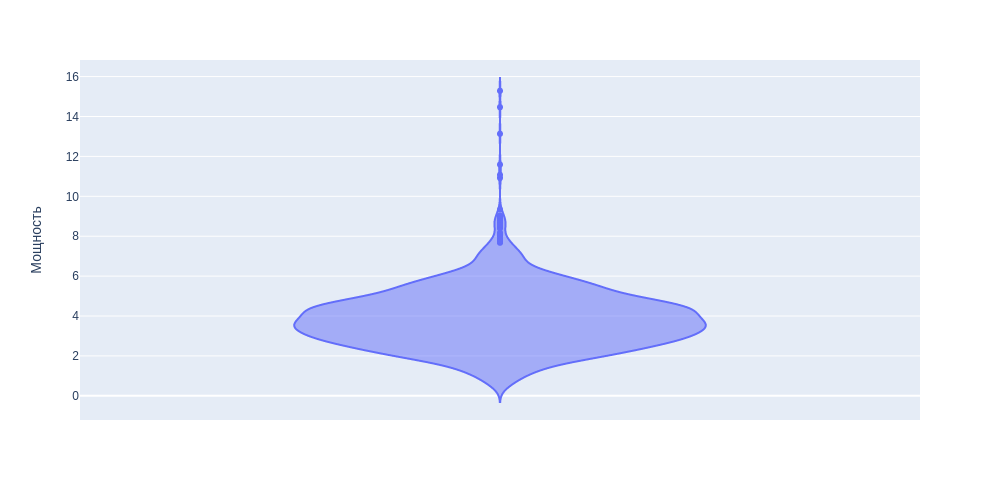

count    2324.000000
mean        3.886143
std         1.517584
min         0.331897
25%         2.846893
50%         3.770584
75%         4.769753
max        15.288271
Name: pow, dtype: float64


In [57]:
columns = {
    'gas': 'Газ',
    'bulk': 'Сыпучие',
    'wire': 'Проволочные',
    'material': 'Материалы',
    'temp_start': 'Начальная темп.',
    'temp_fin': 'Конечная темп.',
    'heat_time_interval': 'Длит. нагр.',
    'pow': 'Мощность'
}

for column in columns:
    display(px.violin(df, y=column, labels=columns))
    print(df[column].describe())

В объёме сыпучих материалов присутствует один особенно большой выброс. Посмотрим на него.

In [58]:
df.query('bulk > 2000')

,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas,bulk,wire,temp_start,temp_fin,heat_time_interval,pow,material
key,,,,,,,,,,,,,,,,
322,101.0,58.0,0.0,1849.0,636.0,0.0,0.0,188.22855,77.99504,3235.0,188.22855,1619.0,1616.0,2658,11.075555,3423.22855


Он действительно всего один. Кажется, мы откинули столбец, где было большое значение объёма какого-то конкретного материала. Ещё его особенно много продували газом (если этот признак связан с количеством газа). Не будем ничего делать.

Проверим корреляцию признаков. Построим матрицы рассеиваний и корреляций. Для матрицы корреляций возьмём значения по модулю.

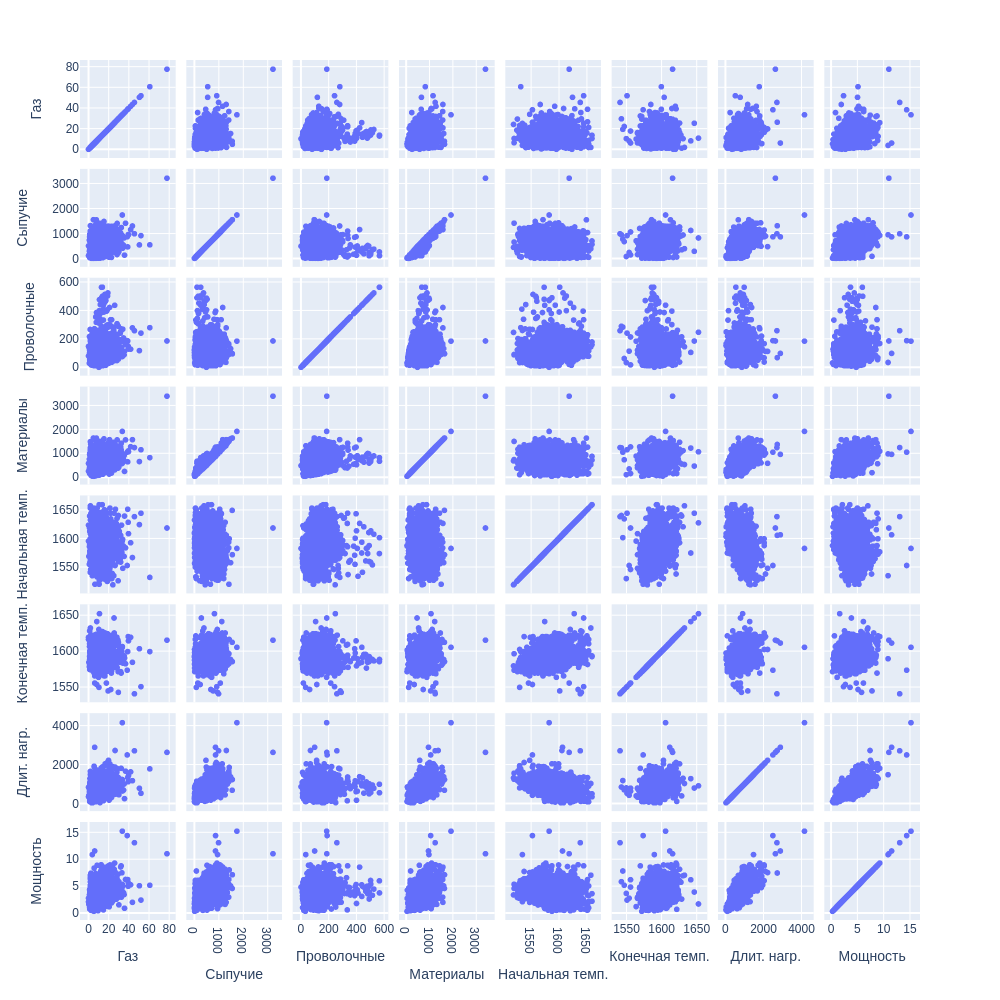

<AxesSubplot:>

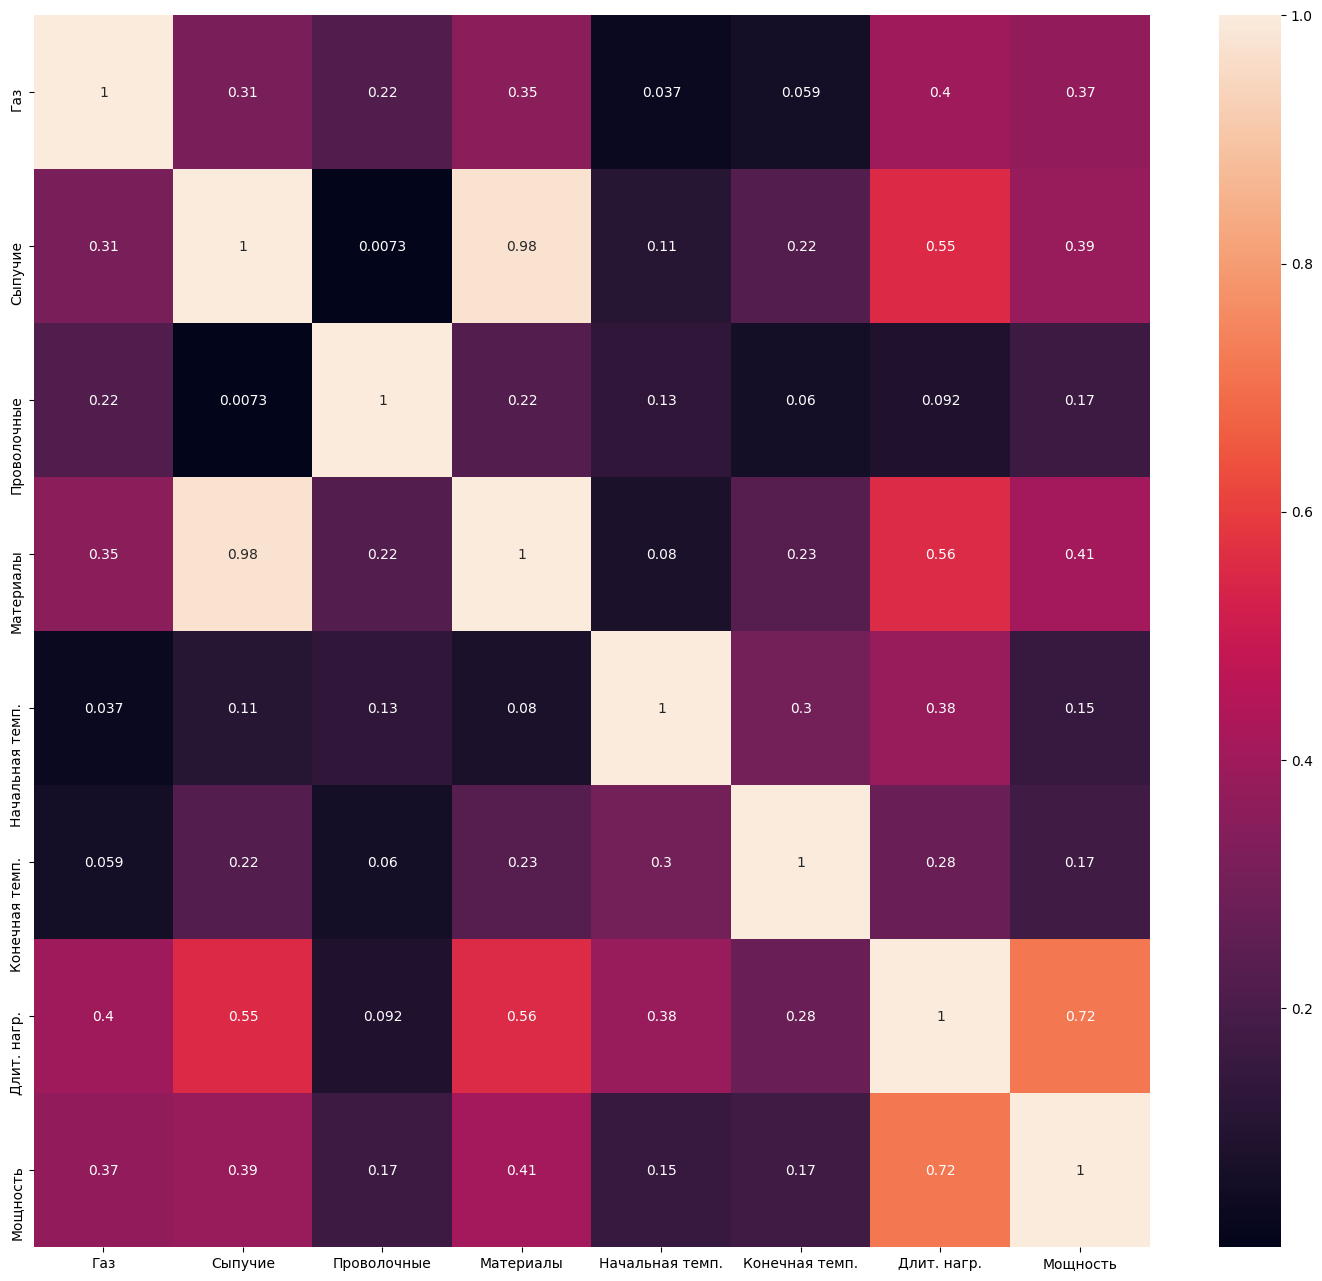

In [59]:
png_renderer.height = 1000
px.scatter_matrix(df[list(columns)].rename(columns=columns)).show()

sns.heatmap(
    df[list(columns)].rename(columns=columns).corr().abs(),
    annot=True
)

Общий объём материалов сильно коррелирует с объёмом сыпучих материалов, но слабо коррелирует с объёмом проволочных материалов. Объём сыпучих материалов (и, соответственно, общий объём материалов) умеренно коррелирует с общим временем нагрева. Действительно заметная корреляция есть у общего времени нагрева и мощности нагрева. Возможно, в иной ситуации имело бы смысл отбросить один из этих признаков, но у нас в данных и так мало наблюдений. К тому же, с корреляцией не умеет работать только классическая линейная регрессия. Так что оставим оба признака.

Теперь построим матрицу корреляций с объёмами конкретных материалов.

<AxesSubplot:>

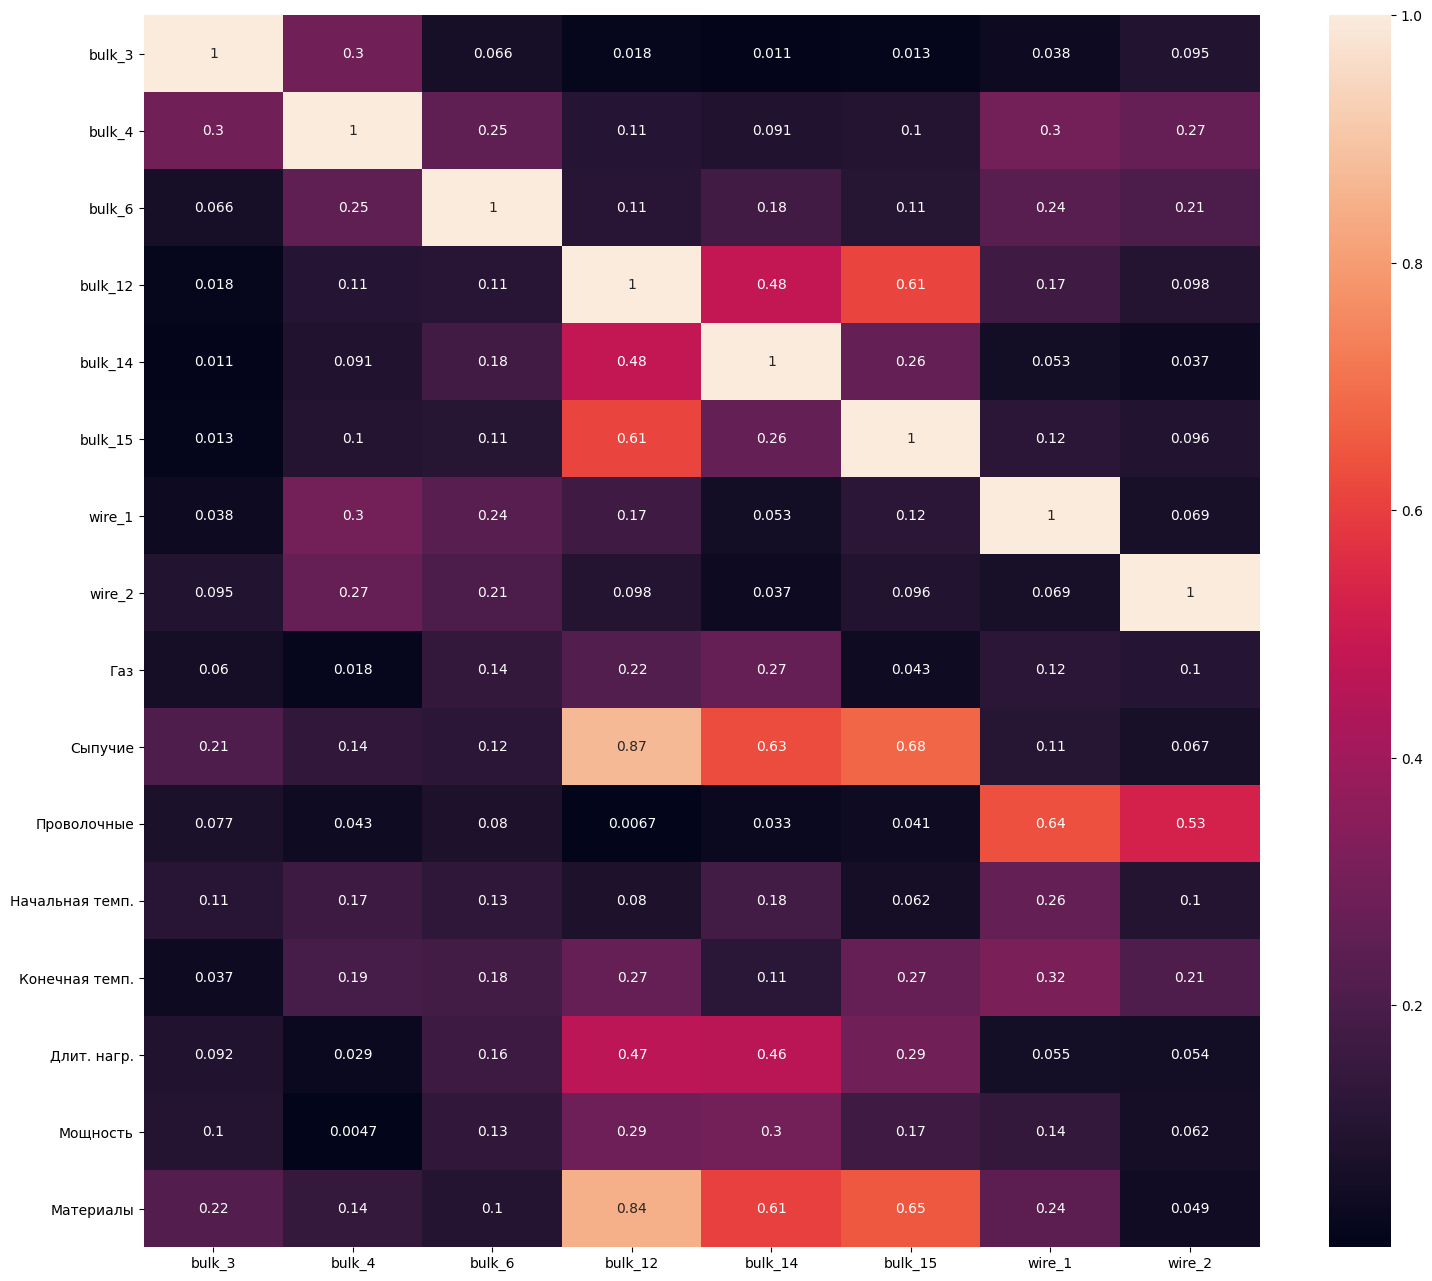

In [60]:
sns.heatmap(
    df.rename(columns=columns).corr().abs().loc[:,'bulk_3':'wire_2'],
    annot=True
)

Столбцы, которые касаются материалов, не коррелируют с другими столбцами. Некоторые коррелируют между собой. Очень умеренно выделяется, разве что, корреляция пары материалов с длительностью нагрева.

Общий объём материалов можно отбросить.

In [61]:
df = df.drop(columns=['material'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bulk_3              2324 non-null   float64
 1   bulk_4              2324 non-null   float64
 2   bulk_6              2324 non-null   float64
 3   bulk_12             2324 non-null   float64
 4   bulk_14             2324 non-null   float64
 5   bulk_15             2324 non-null   float64
 6   wire_1              2324 non-null   float64
 7   wire_2              2324 non-null   float64
 8   gas                 2324 non-null   float64
 9   bulk                2324 non-null   float64
 10  wire                2324 non-null   float64
 11  temp_start          2324 non-null   float64
 12  temp_fin            2324 non-null   float64
 13  heat_time_interval  2324 non-null   int64  
 14  pow                 2324 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 290.5 KB


Мы готовы к тому, чтобы выделять целевой признак и делить данные на выборки.

## Обучение моделей

### Разбиение признаков

Поделим признаки на известные и целевой.

In [62]:
X = df.drop(columns=['temp_fin'], axis=1)
y = df['temp_fin']

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (2324, 14)
y shape: (2324,)


Выделим тестовую выборку. Она будет занимать 25% от всех данных.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=300623
)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1743, 14)
X_test shape: (581, 14)
y_train shape: (1743,)
y_test shape: (581,)


Проверим распределение целевого признака в тренировочной и тестовой выборках.

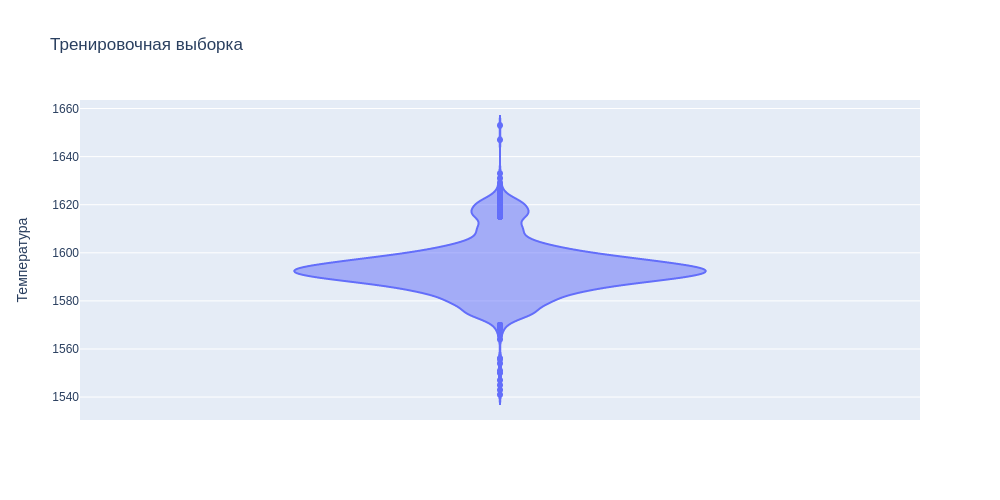

count    1743.000000
mean     1593.429719
std        11.229194
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temp_fin, dtype: float64


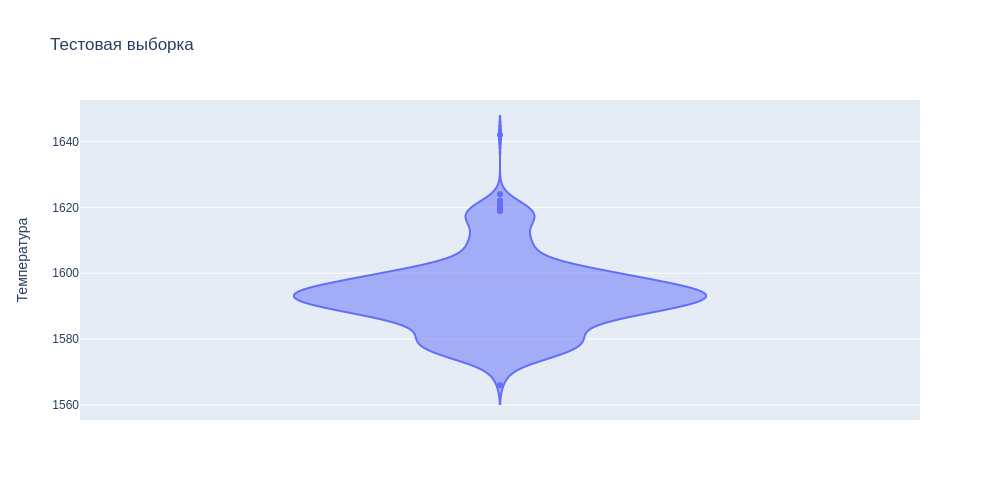

count     581.000000
mean     1593.201377
std        11.149875
min      1566.000000
25%      1586.000000
50%      1593.000000
75%      1599.000000
max      1642.000000
Name: temp_fin, dtype: float64


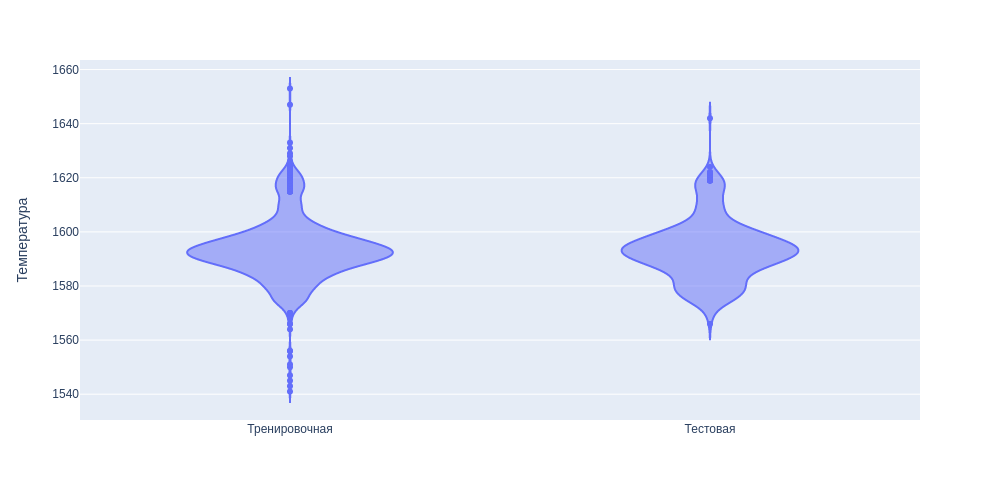

In [64]:
png_renderer.height = 500

display(px.violin(
    y_train,
    y='temp_fin',
    title='Тренировочная выборка',
    labels={'temp_fin': 'Температура'}
))

print(y_train.describe())

display(px.violin(
    y_test,
    y='temp_fin',
    title='Тестовая выборка',
    labels={'temp_fin': 'Температура'}
))

print(y_test.describe())

px.violin(
    pd.DataFrame({'Тренировочная': y_train, 'Тестовая': y_test}),
    labels={'value': 'Температура', 'variable': ''}
)

Распределения немного визуально отличаются. У тестовой выборки целевые значения чуть меньше сосредоточены вокруг среднего.

### Baseline

Узнаем, какой средний MAE мы получим на кроссвалидации, если всегда будем предсказывать среднее.

In [65]:
dummy = DummyRegressor(strategy="mean")

-cross_val_score(
    dummy,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error'
).mean()

8.015665621803967

Средняя MAE на кроссвалидации на тренировочной выборке - 8.0157 градусов. Проверим такой же подход на тестовой выборке.

In [66]:
dummy.fit(X_train, y_train)
DummyRegressor(strategy="mean")
mean_absolute_error(y_test, dummy.predict(X_test))

8.363505657742843

MAE = 8.3635. Нужно добиться качества хотя бы MAE <= 6.8 градусов.

### Обучение

Среди известных признаков есть 6 числовых и нет категориальных. Для нелинейных моделей их готовить не надо. Для линейных моделей в пайплайне сначала добавим полиномиальные признаки, а потом будем их скейлить.

Будем пробовать следующие модели:
- ElasticNet
- Решающее дерево
- Случайный лес
- LGBMRegressor

<br />

- Для ElasticNet будем подбирать уровень влияния пенальти и соотношение между пенальти.
- Для решающего дерева будем подбирать глубину дерева.
- Для случайного леса будем подбирать глубину деревьев и их количество.
- Для LGBMRegressor будем подбирать скорость обучения и количестов листьев.

Для каждой модели, кроме LGBMRegressor, проведём 100 триалов Optuna.

In [67]:
%%time

# Это словарь с моделями, где ключи - названия моделей,
# а значения - сами модели, завёрнутые в анонимную функицю,
# которая принимает объект trial Optuna.
models = {
#     Это единственная линейная модель, так что мы её заворачиваем в пайплайн прямо здесь.
    'ElasticNet': (lambda trial: Pipeline([
        ('PolynomialFeatures', ColumnTransformer(
            [('PolynomialFeatures',
              PolynomialFeatures(include_bias=False),
              list(range(14)))],
            remainder='passthrough'
        )),
        ('MinMaxScaler', ColumnTransformer(
            [('MinMaxScaler',
              MinMaxScaler(),
              list(range(119)))],
            remainder='passthrough'
        )),
        ('model', ElasticNet(
            alpha=trial.suggest_float("alpha", 0.01, 5),
            l1_ratio=trial.suggest_float("l1_ratio", 0, 1),
            random_state=300623,
        ))
    ])),
    
#     Я знаю, что 100 триалов для этой модели слишком,
#     но я хотел оставить код простым.
    'DecisionTreeRegressor': (lambda trial: DecisionTreeRegressor(
        max_depth=trial.suggest_int('max_depth', 1, 20),
        random_state=300623,
    )),
    
    'RandomForestRegressor': (lambda trial: RandomForestRegressor(
        max_depth=trial.suggest_int('max_depth', 1, 20),
        n_estimators=trial.suggest_int('n_estimators', 20, 100),
        random_state=300623,
    )),
    
#     Без GPU LGBMRegressor работает медленно.
#     Лучший результат: MAE: 6.8401786280229775
#     Гиперпараметры: {'learning_rate': 0.00995390510016642, 'num_leaves': 31}
#     'LGBMRegressor': (lambda trial: LGBMRegressor(
#         learning_rate=trial.suggest_float("learning_rate", 0.001, 0.01),
#         num_leaves=trial.suggest_int('num_leaves', 2, 31),
#         random_state=300623,
#     ))
}

# Эта функцию тестирует Optuna, и пытается получить
# лучшую метрику, подбирая гиперпараметры.
def objective(trial):   
    return -cross_val_score(
        models[current_model](trial),
        X_train,
        y_train,
        cv=5,
        scoring='neg_mean_absolute_error'
    ).mean()

# Это функиця скрывает сообщения о ходе прогресса.
# Можно поменять на optuna.logging.INFO, чтобы видеть прогресс.
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Этот цикл итерируется между всеми моделями в словаре models,
# и запускает подбор гиперпараметров с помощью Optuna для каждой.
for current_model in models:
    study = optuna.create_study(
        study_name=current_model,
        sampler=TPESampler(seed=300623)
    )

    study.optimize(objective, n_trials=100)

    print(current_model)
    print(study.best_params)
    print('MAE:', study.best_value)
    print()

ElasticNet
{'alpha': 0.014079711580027519, 'l1_ratio': 0.3641387362376095}
MAE: 6.677339200194228

DecisionTreeRegressor
{'max_depth': 4}
MAE: 7.33758695850904

RandomForestRegressor
{'max_depth': 10, 'n_estimators': 85}
MAE: 6.404862069749282

CPU times: user 5min 12s, sys: 1min 53s, total: 7min 6s
Wall time: 4min 19s


Только у двух из четырёх моделей удовлетворительное для задачи качество. Лучшая модель - случайный лес с метрикой MAE = 6.4. Вот топ моделей:
1. Случайный лес, MAE = 6.4
    - Максимальная глубина: 10
    - Количество деревьев: 85
1. ElasticNet, MAE = 6.68
    - alpha: 0.014079711580027519
    - l1_ratio: 0.3641387362376095
1. LGBMRegressor, MAE = 6.84
    - Скорость обучения: 0.00995390510016642
    - Количество листьев: 31
1. Решающее дерево, MAE = 7.34
    - Максимальная глубина: 4
    
*у всех моделей random_state=300623.

Мы готовы тестировать лучшую модель.

## Тестирование

Лучшая модель, которую нам удалось найти, это случайный лес со следующими гиперпараметрами:

In [68]:
model = RandomForestRegressor(
    max_depth=10,
    n_estimators=85,
    random_state=300623,
)

Посчитаем MAE на тестовой выборке.

In [69]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)
mean_absolute_error(y_test, prediction)

6.28554778642918

MAE = 6.29. Задаче всё ещё удовлетворяет.

Посмотрим, как модель ошибается.

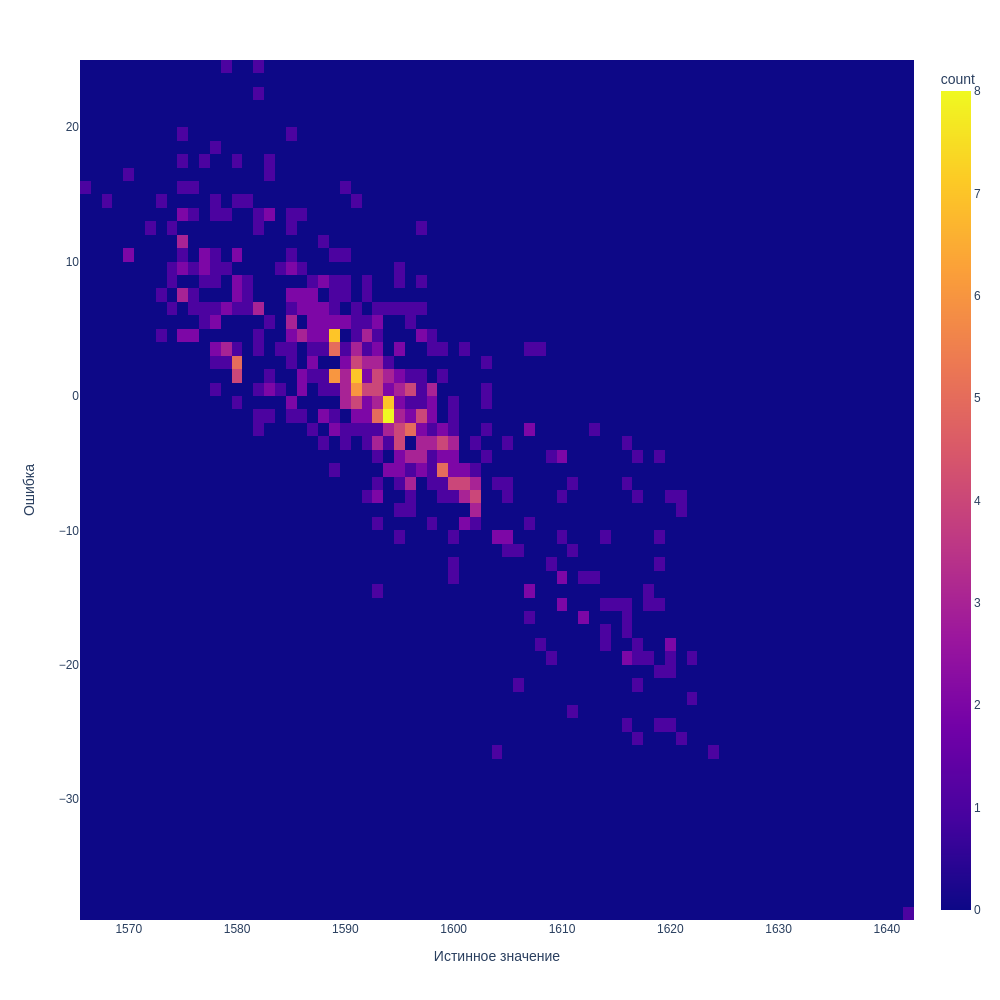

In [70]:
errors = pd.DataFrame(data={
    'Истинное значение': y_test,
    'Ошибка': prediction - y_test
})

png_renderer.height = 1000

px.density_heatmap(
    errors,
    x='Истинное значение',
    y='Ошибка',
    nbinsx=100,
    nbinsy=100,
)

Для расплавов с истинным значениями температуры меньше 1595 наша модель часто предсказывает больше чем надо, а для остальных расплавов - меньше. Иными словами, модель часто предсказывает ближе к медиане.

Построим столбчатую диаграмму важности признаков.

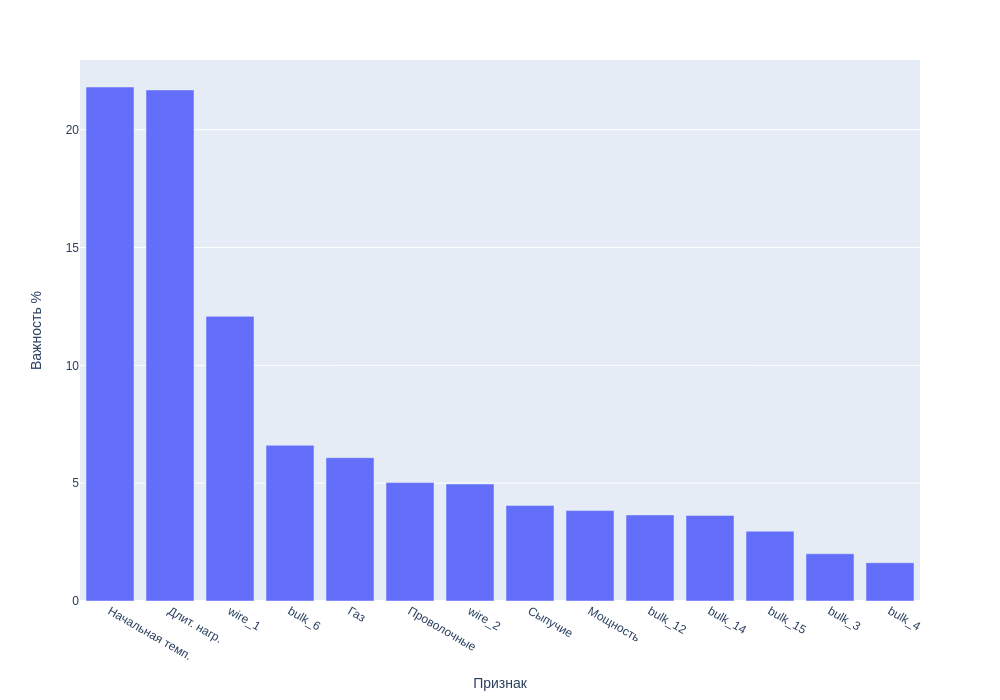

In [71]:
png_renderer.height = 700

px.bar(
    pd.DataFrame({
        'Признак': X.rename(columns=columns).columns,
        'Важность %': model.feature_importances_ * 100
    }).sort_values(by='Важность %', ascending=False),
    x='Признак',
    y='Важность %'
)

Два самых важных признака это начальная температура и общая длительность нагрева по 20% с лишним условной важности каждый. Третий по важности признак это объём конкретного проволочного материала: 12% условной важности. Важность остальных признаков относительно равномерно без особо сильных скачков снижается с 6% до 1.6%. Каждый из оставшихся признаков повышает точность модели на немного.

## Отчёт

### Модель

Лучшая модель, которую удалось найти, это случайный лес с MAE = 6.29 градуса на тестовой выборке и со следующими гиперпараметрами:

In [72]:
RandomForestRegressor(
    max_depth=10,
    n_estimators=85,
    random_state=300623,
)

RandomForestRegressor(max_depth=10, n_estimators=85, random_state=300623)

### Признаки

Эта модель принимает на вход 14 признаков, которые обладают разной важностью для модели. Три самых важных признака это температура расплава в начале этапа, общая длительность нагреваний расплава электродами и объём добавленного в расплав конкретного проволочного материала, который обозначен в данной таблице как Wire 1. Они вместе важны для модели на условные 60%.

Остальные 40% делят между собой остальные 11 признаков. Это значение газа, общий объём добавленных проволочных материалов, общий объём сыпучих материалов, общая мощность всех нагреваний электродами и объём семи других конкретных материалов, как проволочных, так и сыпучих.

Для того, чтобы получить признаки, связанные с объёмами материалов, пропуски в таблицах data_bulk_new.csv и data_wire_new.csv были заполнены нулями. Затем оттуда взяли признаки: Wire 1, Wire 2, Bulk 3, Bulk 4, Bulk 6, Bulk 12, Bulk 14, Bulk 15. Общий объём сыпучих материалов это сумма объёмов всех добавленных сыпучих материалов (не только из перечисленных). Аналогично с общим объёмом проволочных материалов.

Общее время нагреваний электродами находится следующим образом. Для каждого нагревания из таблицы data_arc_new.csv находится длительность конкретных нагреваний. Для этого время начала нагревания вычитается из времени конца нагревания. Полученное значение конвертируется в число секунд. Затем для каждого расплава находится сумма длительностей всех нагреваний.

Общая мощность нагреваний электродами находится следующим образом. Для каждого нагревания из таблицы data_arc_new.csv находится общая мощность по формуле корня суммы квадратов активной и реактивной мощностей. Затем для каждого расплава находится сумма всех общих мощностей.

Значение газа напрямую взято из таблицы data_gas_new.csv. Начальная температура расплава это самый первый замер температуры расплава из таблицы data_temp_new.csv. Признак, который модель предсказывает, это самый последний замер температуры расплава из этой же таблицы.

### Ошибки модели

Метрика MAE удовлетворяет поставленной задаче, но стоит обратить внимание на то, как модель ошибается. Когда реальный целевой признак отклоняется от среднего, модель всё-равно склонна предсказывать ближе к среднему.

Надо подумать, как именно используются предсказания модели, и как они помогают повысить энергоэффективность. Возможно, интересна другая метрика модели, которая сильнее пенализирует сильные отклонения от реальных значений. Или, возможно, будет интересна особая метрика модели, которая будет слабо пенализировать модель за предсказания далёкие от среднего, когда реальное значение близко к среднему, но будет сильнее пенализировать модель, когда ситуация обратная. Или нужна просто модель, которая будет предсказывать само наличие сильных отклонений, а не конкретную температуру.

### Качество данных

Выборка, с которой пришлось работать, содержит информацию по всего трём тысячам расплавов с лишним. Возможно, если бы выборка была больше, то удалось бы получить метрику лучше. Ситуацию усугубляет то, что данные пришлось чистить от проблем, что сильно сократило и без того небольшую выборку до 2324 вхождений.

Самая большая проблема это пропуски в таблице с замерами температур в столбце самих температур. Только из-за них пришлось отбросить около 700 вхождений. Из-за остальных проблем не пришлось откидывать слишком много. Например, часть расплавов пришлось откинуть из-за того, что не все они присутствовали во всех таблицах. Ещё немного пришлось откинуть из-за аномальных значений.

Тем не менее, эти проблемы, даже если их немного, снижают доверие к данным. Откуда пропуски в таблице с температурами? Откуда взялись 4 расплава, у которых температура в начале этапа в районе 1200 градусов? Почему у одного из нагревов была отрицательная реактивная мощность? Эти проблемы заставляются усомниться во всех остальных данных. Оборудование, которое собирает эту информацию работает исправно? В таблицах информация корректна? Потому что, если нет, то модель не сможет давать нормальные предсказания в реальной работе.

Также стоит подумать, есть ли ещё информация, которую можно собирать. Возможно, у того, кто работает с расплавом, должна быть возможность по желанию оставить и сохранить текстовый комментарий по поводу работы с этим расплавом. Например, на случай, если в процессе этапа были какие-то аномалии или ошибки. Собрав достаточное количество комментариев, возможно, на их основе удастся принять осмысленные решения. На что обратить внимание, или какую информацию ещё надо собирать.